# The role of informality on Covid-19 spread

In [3]:
# modulos necesarios 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as datetime 
import warnings
import requests 
import geopandas as gpd 
import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')

In [4]:
nombre_carpeta_tesis = 'Tesis'
path_tesis = '/users/efrainrodriguez/desktop/' + nombre_carpeta_tesis

## Databases used in the study

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # From geopandas library
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [5]:
# Our World in Data Covid-19 Database
covid_gen = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv',parse_dates=True) 
covid_gen['stringency_index_median'] = covid_gen.groupby('location')['stringency_index'].transform('median')
covid_gen['stringency_index_mean'] = np.log(covid_gen.groupby('location')['stringency_index'].transform('mean'))
covid_gen['date'] = pd.to_datetime(covid_gen['date'])

In [6]:
def get_first_dates(location='Mexico',threshold=1):
    try:
        return (covid_gen[(covid_gen['location']==location)&(covid_gen['total_cases_per_million']>=threshold)][['date','total_cases_per_million']].reset_index()['date'][0]-datetime.datetime.strptime('2020-01-01','%Y-%m-%d')).days
    except Exception:
        return 0

In [7]:
covid_gen['Days_pre_pandemic'] = covid_gen['location'].apply(lambda x: get_first_dates(location=x,threshold=1))

In [8]:
covid_recortada = covid_gen[covid_gen['date'].astype('str')=='2020-12-31'].copy()
covid_recortada.rename(columns={'location':'Country'},inplace=True)
covid_recortada.head()

,iso_code,continent,Country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,stringency_index_median,stringency_index_mean,Days_pre_pandemic
311,AFG,Asia,Afghanistan,2020-12-31,52330.0,0.0,139.000,2189.0,0.0,9.000,...,0.50,64.83,0.511,NaN,NaN,NaN,NaN,27.78,3.590539,82
1072,OWID_AFR,NaN,Africa,2020-12-31,2760454.0,29789.0,23078.857,65468.0,699.0,576.714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
1821,ALB,Europe,Albania,2020-12-31,58316.0,589.0,498.429,1181.0,7.0,8.000,...,2.89,78.57,0.795,5812.4,26.67,54.60,2023.158207,56.48,4.024139,69
2570,DZA,Africa,Algeria,2020-12-31,99610.0,299.0,371.857,2756.0,5.0,7.286,...,1.90,76.88,0.748,49888.7,26.86,29.47,1118.163888,70.83,4.157305,74
3313,AND,Europe,Andorra,2020-12-31,8049.0,66.0,50.000,84.0,0.0,0.143,...,NaN,83.73,0.868,89.6,27.20,31.41,1158.311141,50.00,3.865933,61


In [10]:
covid_recortada.to_csv(path_tesis + '/Bases/Covid_recortada_20220315.csv')

In [5]:
covid_recortada = pd.read_csv(path_tesis + '/Bases/Covid_recortada_20220315.csv')

In [6]:
# IMF Real GDP Growth for 2020 (WEO April 2021)

covid_gdp = pd.read_excel(path_tesis + '/Bases/GDP_2020.xls')
covid_gdp.head()

,Country,Real GDP growth (Annual percent change)
0,Afghanistan,-2.4
1,Albania,-3.3
2,Algeria,-4.9
3,Andorra,-12.0
4,Angola,-5.4


In [347]:
# Change in the unemployment rate 

covid_unem = pd.read_excel(path_tesis +'/Bases/change_gdp.xls')[['Real GDP growth (Annual percent change)','Change']]
covid_unem.columns = ['Country','Change_gdp']
covid_unem.head()

,Country,Change_gdp
0,Afghanistan,-6.3
1,Albania,-5.5
2,Algeria,-5.7
3,Andorra,-14.0
4,Angola,-4.9


In [8]:
# Income support policies

covid_income_support = pd.read_csv(path_tesis + '/Bases/income-support-covid.csv')
covid_income_support_prom = pd.DataFrame(covid_income_support.groupby('Entity')['income_support'].median()).reset_index()
covid_income_support_prom['income_support'] = covid_income_support_prom['income_support'].apply(lambda x: x/2)
covid_income_support_prom.columns = ['Country','income_support']
covid_income_support_prom.head()

,Country,income_support
0,Afghanistan,0.0
1,Albania,0.5
2,Algeria,0.0
3,Andorra,1.0
4,Angola,0.0


In [9]:
# Debt relief policies 

covid_debt_relief = pd.read_csv(path_tesis + '/Bases/debt-relief-covid.csv')
covid_debt_relief_prom = pd.DataFrame(covid_debt_relief.groupby('Entity')['debt_relief'].median()).reset_index()
covid_debt_relief_prom['debt_relief'] = covid_debt_relief_prom['debt_relief'].apply(lambda x: x/2)
covid_debt_relief_prom.columns = ['Country','debt_relief']
covid_debt_relief_prom.head()

,Country,debt_relief
0,Afghanistan,0.0
1,Albania,0.5
2,Algeria,1.0
3,Andorra,1.0
4,Angola,0.0


In [10]:
# Composition of economies 

comp_econ = pd.read_excel(path_tesis + '/Bases/composicion_econ.xlsx')
comp_econ.rename(columns={'Country ':'Country'},inplace=True)
comp_econ['Agriculture'] = comp_econ['Agriculture']/100
comp_econ['Industry'] = comp_econ['Industry']/100
comp_econ['Manufacturing '] = comp_econ['Manufacturing ']/100
comp_econ['Services'] = comp_econ['Services']/100

comp_econ['Total'] = comp_econ['Services'] + comp_econ['Manufacturing '] + comp_econ['Industry'] + comp_econ['Agriculture']

comp_econ.head()

,Country,Agriculture,Industry,Manufacturing,Services,Total
0,Afghanistan,0.26,0.14,0.07,0.5550,1.025
1,Albania,0.18,0.20,0.06,0.4860,0.926
2,Algeria,0.12,0.37,0.24,0.4620,1.192
3,American Samoa,NaN,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,NaN,0.7279,NaN


In [11]:
# Informality Database

informalidad = pd.read_excel(path_tesis+'/Bases/informalidad_2.xlsx')
informalidad.rename(columns={'Location':'Country'},inplace=True)
informalidad['informality'] = informalidad['Informality'].apply(lambda x: x/100)
informalidad['male_informality'] = informalidad['Male informality'].apply(lambda x: x/100)
informalidad['female_informality'] = informalidad['Female informality'].apply(lambda x: x/100)
informalidad['diff_male_female'] = informalidad['male_informality'] - informalidad['female_informality']
informalidad.head()

,Country,Informality,Male informality,Female informality,informality,male_informality,female_informality,diff_male_female
0,Albania,61.00000,59.000000,63.500000,0.610000,0.590000,0.635000,-0.045000
1,Afghanistan,66.58692,65.504091,68.733666,0.665869,0.655041,0.687337,-0.032296
2,Angola,84.30000,77.200000,91.300000,0.843000,0.772000,0.913000,-0.141000
3,Argentina,47.20000,47.100000,47.200000,0.472000,0.471000,0.472000,-0.001000
4,Armenia,52.10000,52.800000,51.400000,0.521000,0.528000,0.514000,0.014000


In [12]:
# Non agricultural informality

informalidad_nonag = pd.read_csv(path_tesis + '/Bases/Informality-report-nonagriculture.csv')
informalidad_nonag.columns = ['Country','inf_na','iso_code']
informalidad_nonag['inf_na'] = informalidad_nonag['inf_na'].apply(lambda x: x/100)
informalidad_nonag.head()

,Country,inf_na,iso_code
0,Albania,0.331000,ALB
1,Afghanistan,0.828503,AFG
2,Angola,0.756143,AGO
3,Argentina,0.470000,ARG
4,Armenia,0.265000,ARM


In [13]:
# Stay at home orders  

stay_home = pd.read_csv(path_tesis + '/Bases/stay-at-home-covid.csv')
stay_home = stay_home[(pd.to_datetime(stay_home['Day']).dt.date>datetime.date(2020,1,26))&(pd.to_datetime(stay_home['Day']).dt.date<=datetime.date(2020,12,31))]

stay_home_grouped = pd.DataFrame(stay_home.groupby(['Entity','stay_home_requirements'])['Day'].count()/340).reset_index()
stay_home_grouped['stay_home_w_avg'] = stay_home_grouped['stay_home_requirements']*stay_home_grouped['Day']

stay_home_averages = pd.DataFrame(stay_home_grouped.groupby('Entity')['stay_home_w_avg'].sum()/3).reset_index()
stay_home_averages.columns = ['Country','stay_home_w_avg']
stay_home_averages.head()

,Country,stay_home_w_avg
0,Afghanistan,0.301961
1,Albania,0.415686
2,Algeria,0.588235
3,Andorra,0.113725
4,Angola,0.400980


In [14]:
# Country correlations with Google mobility index

correlations_stay_home = pd.read_csv(path_tesis + '/Bases/correlaciones_.csv').drop(['Unnamed: 0'],axis=1)
correlations_stay_home.rename(columns={'country':'Country'},inplace=True)
correlations_stay_home.head()

,Country,correlation_retail,correlation_grocery,correlation_parks,correlation_transit,correlation_workplace,correlation_residential
0,United Arab Emirates,-0.730812,-0.698268,-0.519064,-0.630237,-0.587489,0.657272
1,Afghanistan,-0.763132,-0.621935,-0.614027,-0.650827,-0.674369,0.571033
2,Angola,-0.546009,-0.448346,-0.481081,-0.663467,-0.341505,0.666950
3,Argentina,-0.821500,-0.584311,-0.808608,-0.836452,-0.696981,0.788091
4,Austria,-0.758379,-0.373568,-0.639433,-0.702365,-0.500435,0.695554


In [15]:
# Globalization index

globalization = pd.read_csv('/users/efrainrodriguez/downloads/GCI Data Country Results.csv',usecols=['Country','Depth Score'])
globalization.head()

,Country,Depth Score
0,Netherlands,44.3764
1,Singapore,49.5794
2,Belgium,44.8629
3,United Arab Emirates,43.9467
4,Ireland,42.5642


In [16]:
# Base excess deaths 

excess_deaths = pd.read_csv('https://raw.githubusercontent.com/TheEconomist/covid-19-the-economist-global-excess-deaths-model/main/output-data/export_country_per_100k_cumulative.csv')
excess_cumul = excess_deaths[excess_deaths['date']=='2020-12-28'].copy()
excess_cumul.head()

,iso3c,date,population,cumulative_estimated_daily_excess_deaths_per_100k,cumulative_estimated_daily_excess_deaths_ci_95_top_per_100k,cumulative_estimated_daily_excess_deaths_ci_90_top_per_100k,cumulative_estimated_daily_excess_deaths_ci_50_top_per_100k,cumulative_estimated_daily_excess_deaths_ci_50_bot_per_100k,cumulative_estimated_daily_excess_deaths_ci_90_bot_per_100k,cumulative_estimated_daily_excess_deaths_ci_95_bot_per_100k,cumulative_estimated_daily_excess_deaths_raw_estimate_per_100k,cumulative_daily_excess_deaths_per_100k,cumulative_daily_covid_deaths_per_100k
11648,ABW,2020-12-28,107195,45.173324,45.173324,45.173324,45.173324,45.173324,45.173324,45.173324,66.725764,45.173324,47.282678
11649,AFG,2020-12-28,39835428,44.473481,92.041071,85.958818,65.747022,41.214335,28.412030,21.778702,44.473481,0.000000,5.462472
11650,AGO,2020-12-28,33933611,22.180520,50.795274,34.614440,22.180520,-15.074725,-50.823330,-67.405511,22.180520,0.000000,1.222473
11651,AIA,2020-12-28,15125,-36.228180,64.816232,40.309715,4.834115,-36.228180,-54.312936,-61.752347,-36.228180,0.000000,0.000000
11652,ALB,2020-12-28,2872934,219.543876,219.543876,219.543876,219.543876,219.543876,219.543876,219.543876,180.784435,219.543876,40.523126


In [17]:
# Female share 

female_share = pd.read_csv(path_tesis + '/Bases/share-population-female.csv')
female_share.columns = ['Country','code','Year','Female_share']
female_share = female_share[female_share['Year']<2020]
female_share.drop_duplicates(subset=['Country'],keep='last',inplace=True)
female_share.head()

,Country,code,Year,Female_share
59,Afghanistan,AFG,2019,48.662395
120,Africa Eastern and Southern,NaN,2019,50.373008
181,Africa Western and Central,NaN,2019,49.702868
242,Albania,ALB,2019,49.086106
303,Algeria,DZA,2019,49.481712


## Figures used in the study

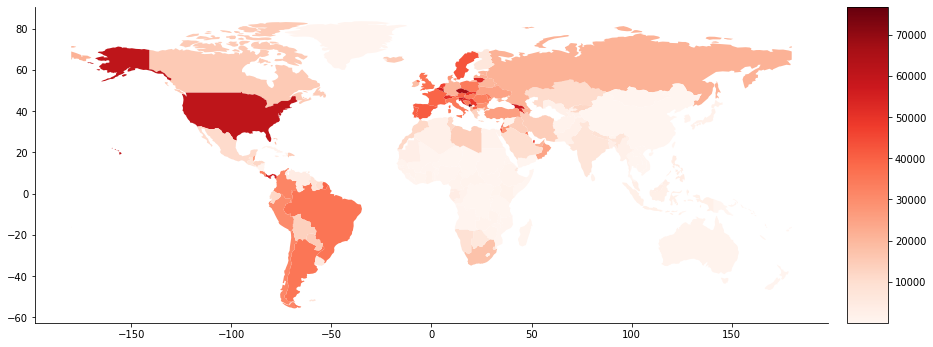

In [19]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world['iso_a3'][43] = 'FRA'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(covid_recortada,left_on='iso_a3',right_on='iso_code').plot(column='total_cases_per_million',cmap='Reds',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_covid_casos.png',bbox_inches='tight')
plt.show()

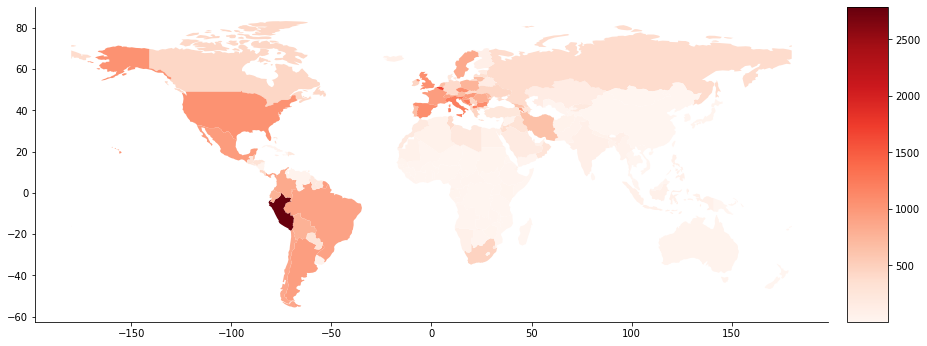

In [20]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world['iso_a3'][43] = 'FRA'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(covid_recortada,left_on='iso_a3',right_on='iso_code').plot(column='total_deaths_per_million',cmap='Reds',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_covid_muertes.png',bbox_inches='tight')
plt.show()

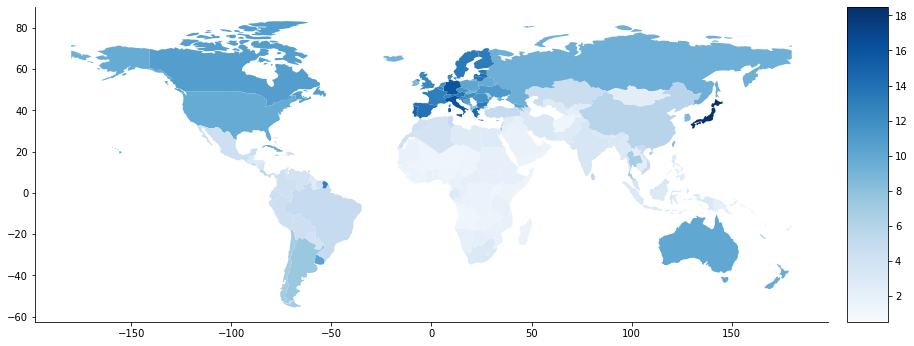

In [21]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world['iso_a3'][43] = 'FRA'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(covid_recortada,left_on='iso_a3',right_on='iso_code').plot(column='aged_70_older',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_covid_edad.png',bbox_inches='tight')
plt.show()

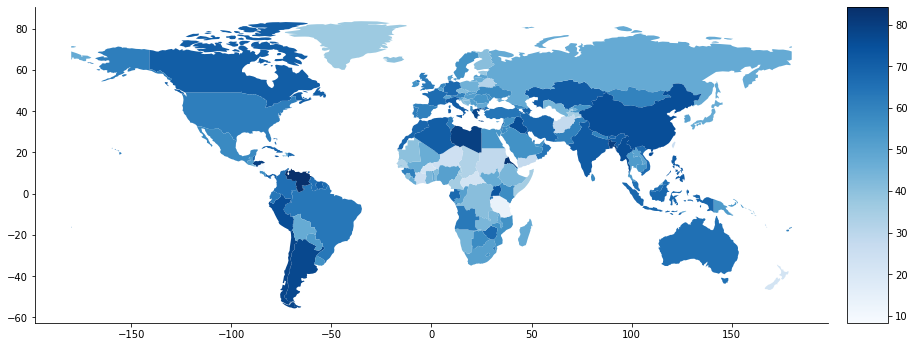

In [22]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world['iso_a3'][43] = 'FRA'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(covid_recortada,left_on='iso_a3',right_on='iso_code').plot(column='stringency_index_median',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_covid_string.png',bbox_inches='tight')
plt.show()

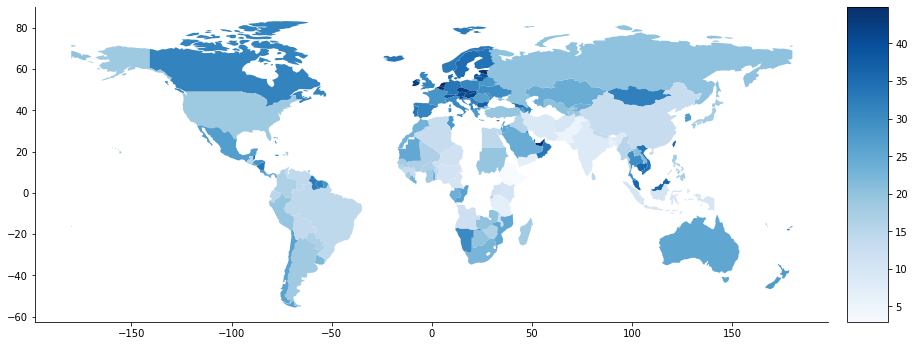

In [23]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world['iso_a3'][43] = 'FRA'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(globalization,left_on='name',right_on='Country').plot(column='Depth Score',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_global_depth.png',bbox_inches='tight')
plt.show()

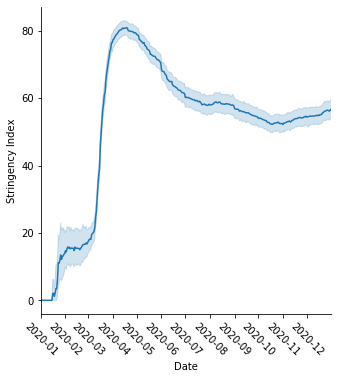

In [24]:
# Stringency index graphs

covid_gen['date'] = pd.to_datetime(covid_gen['date'])
sns.relplot(x='date',y='stringency_index',data=covid_gen,kind='line',ax=ax)
plt.xlim(datetime.date(2020,1,1),datetime.date(2020,12,31))
plt.xticks(rotation=-45)
plt.ylabel('Stringency Index')
plt.xlabel('Date')
plt.savefig(path_tesis + '/Graficas/string_2020.png',bbox_inches='tight')
plt.show()

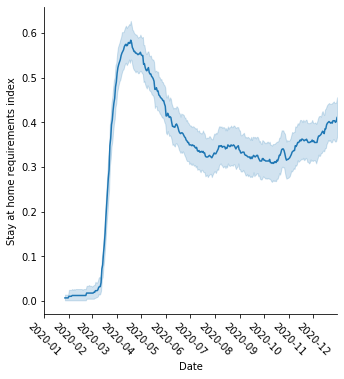

In [24]:
stay_home['stay_home'] = stay_home['stay_home_requirements'].apply(lambda x: x/3)
stay_home['Day'] = pd.to_datetime(stay_home['Day'])
sns.relplot(x='Day',y='stay_home',data=stay_home,kind='line',ax=ax)
plt.xlim(datetime.date(2020,1,1),datetime.date(2020,12,31))
plt.xticks(rotation=-45)
plt.ylabel('Stay at home requirements index')
plt.xlabel('Date')
plt.savefig(path_tesis + '/Graficas/stay_home_2020.png',bbox_inches='tight')
plt.show()

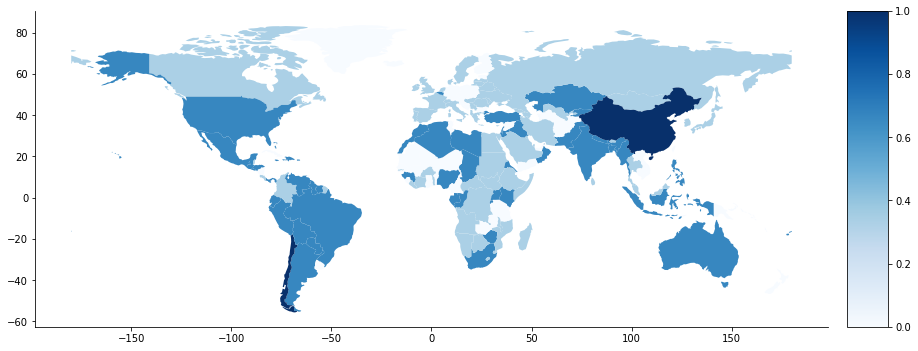

In [25]:
# Stay at home 

stay_h_median = pd.DataFrame(stay_home.groupby(['Entity','Code'])['stay_home'].median()).reset_index()

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world['iso_a3'][43] = 'FRA'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(stay_h_median,left_on='iso_a3',right_on='Code').plot(column='stay_home',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/stay_h_median.png',bbox_inches='tight')
plt.show()

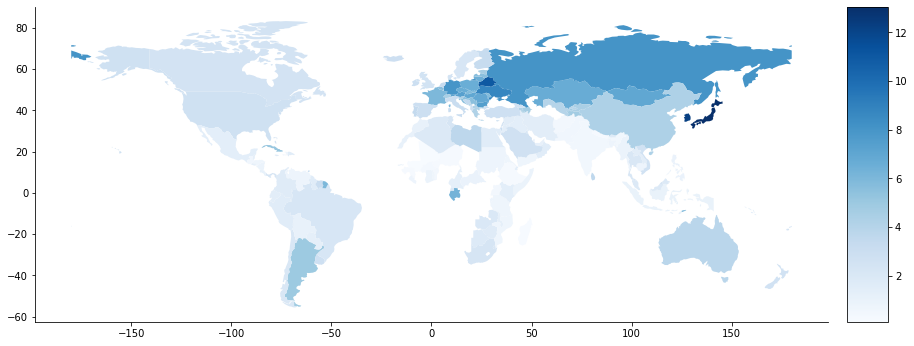

In [26]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world['iso_a3'][43] = 'FRA'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(covid_recortada,left_on='iso_a3',right_on='iso_code').plot(column='hospital_beds_per_thousand',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_covid_camas_hosp.png',bbox_inches='tight')
plt.show()

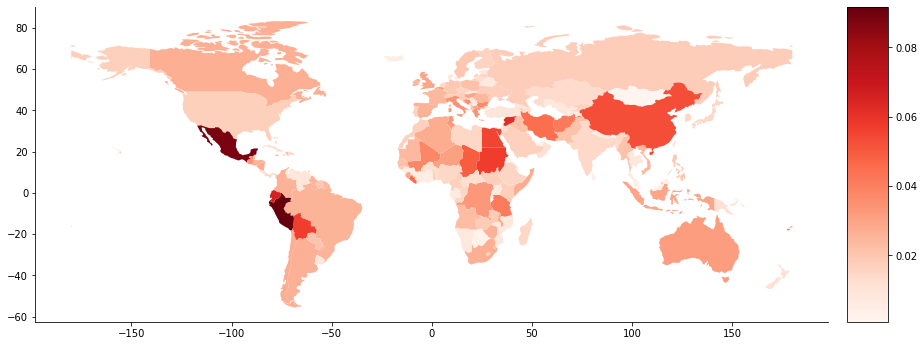

In [27]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world['iso_a3'][43] = 'FRA'
covid_recortada['mortality_rate'] = covid_recortada['total_deaths_per_million']/covid_recortada['total_cases_per_million']
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(covid_recortada[covid_recortada['mortality_rate']<0.20],left_on='iso_a3',right_on='iso_code').plot(column='mortality_rate',cmap='Reds',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_covid_mort_rate.png',bbox_inches='tight')
plt.show()

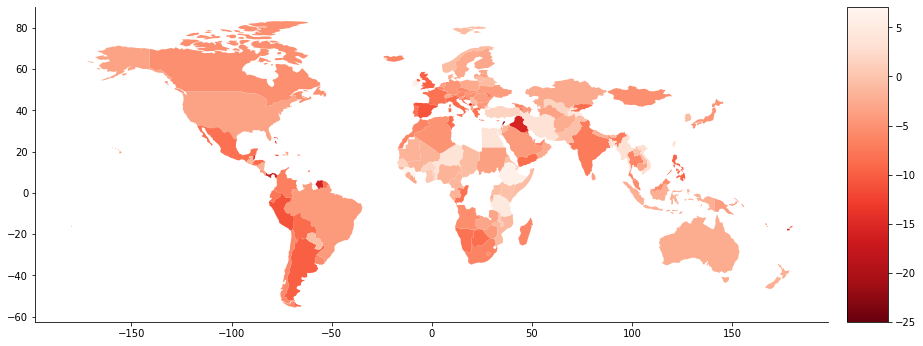

In [28]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
fig.set_size_inches(15.5, 15.5)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
cax = divider.append_axes("right", size="5%", pad=0.1)
world.merge(covid_gdp[(covid_gdp['Real GDP growth (Annual percent change)']>-30)&(covid_gdp['Real GDP growth (Annual percent change)']<20)],left_on='name',right_on='Country').plot(column='Real GDP growth (Annual percent change)',cmap='Reds_r',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/mapa_1.png',bbox_inches='tight')
plt.show()


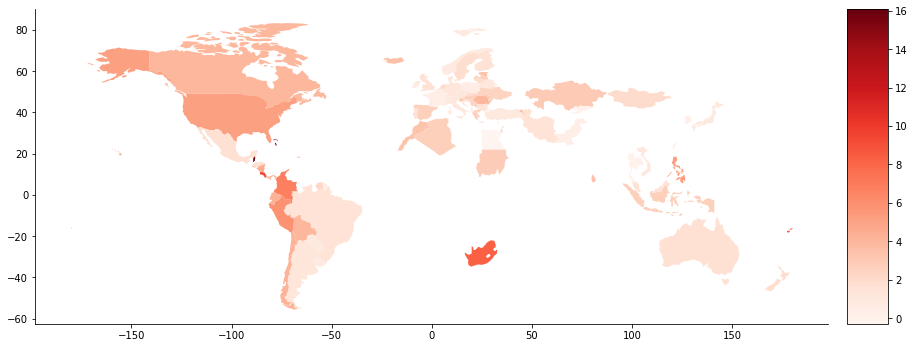

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China, People's Republic of"
world.loc[world['iso_a3']=='RUS','name'] = 'Russian Federation'
world.merge(covid_unem,left_on='name',right_on='Country').plot(column='Unemployment rate change (PP)',cmap='Reds',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/unem.png',bbox_inches='tight')
plt.show()


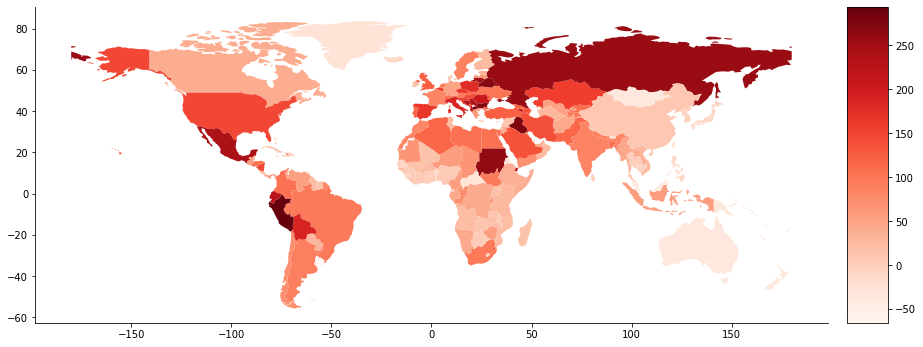

In [30]:
# Excess deaths 

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world.loc[world['name']=='France','iso_a3']  = 'FRA'
world.merge(excess_cumul,left_on='iso_a3',right_on='iso3c').plot(column='cumulative_estimated_daily_excess_deaths_per_100k',cmap='Reds',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/excess_deaths.png',bbox_inches='tight')
plt.show()

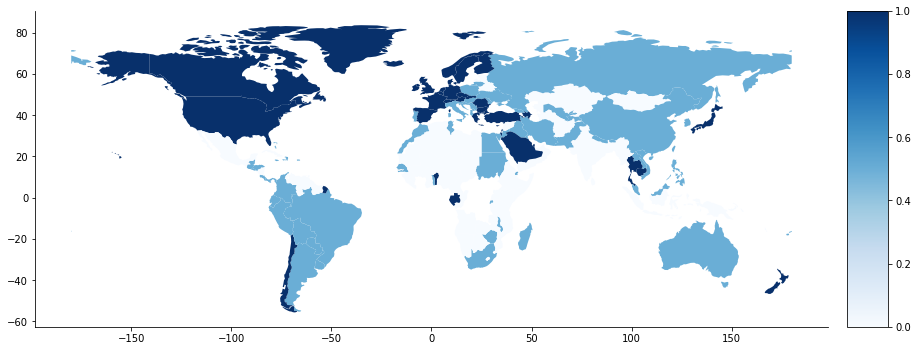

In [31]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world.merge(covid_income_support_prom,left_on='name',right_on='Country').plot(column='income_support',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/covid_income_su.png',bbox_inches='tight')
plt.show()

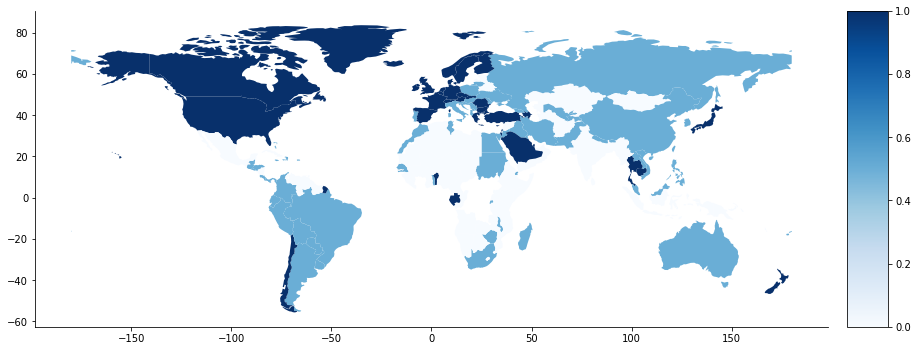

In [32]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world.merge(covid_income_support_prom,left_on='name',right_on='Country').plot(column='income_support',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/debt_relief.png',bbox_inches='tight')
plt.show()

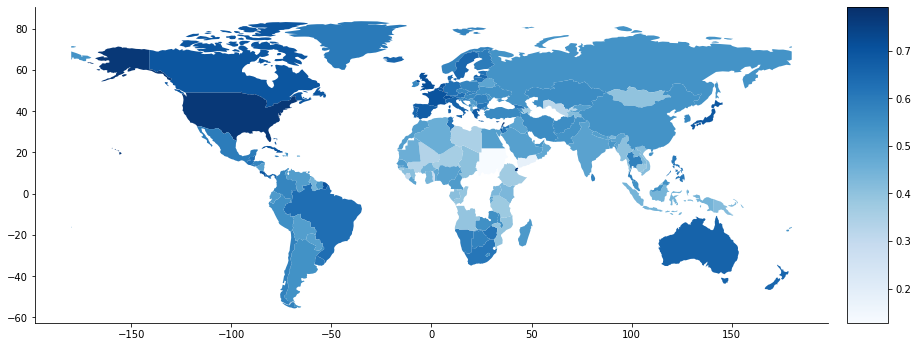

In [33]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] ="China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
comp_econ['Country'][59] = 'Egypt'
comp_econ['Country'][90] = 'Iran'

world.merge(comp_econ,left_on='name',right_on='Country').plot(column='Services',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/serv.png',bbox_inches='tight')
plt.show()

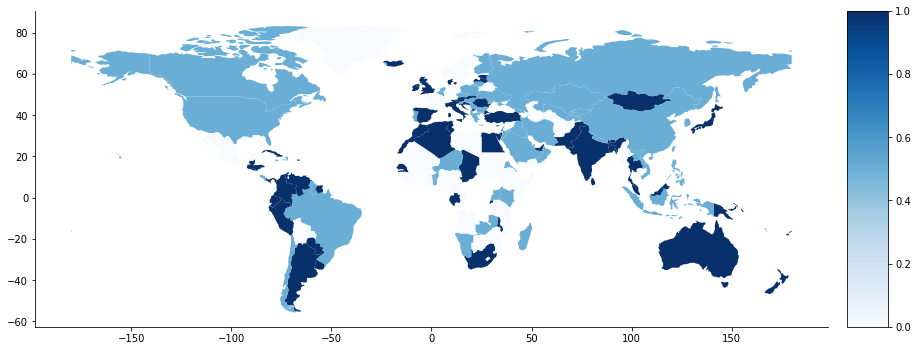

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world.merge(covid_debt_relief_prom,left_on='name',right_on='Country').plot(column='debt_relief',cmap='Blues',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/debt_relief.png',bbox_inches='tight')
plt.show()

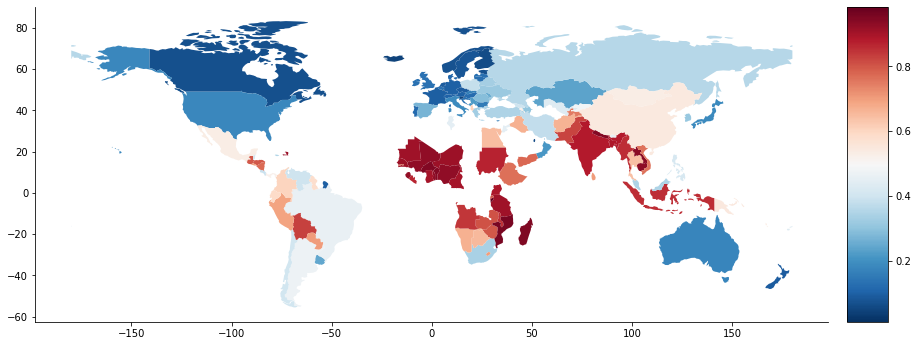

In [35]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world.merge(informalidad,left_on='name',right_on='Country').plot(column='informality',cmap='RdBu_r',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/labor_informality.png')
plt.show()

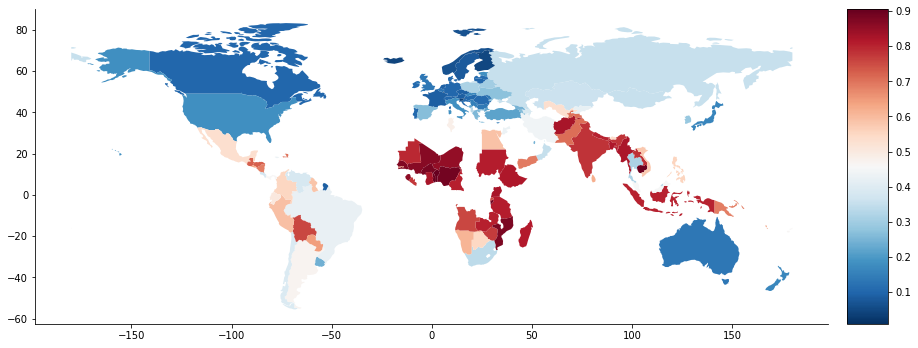

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world.merge(informalidad_nonag,left_on='name',right_on='Country').plot(column='inf_na',cmap='RdBu_r',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/nonag_labor_informality.png')
plt.show()

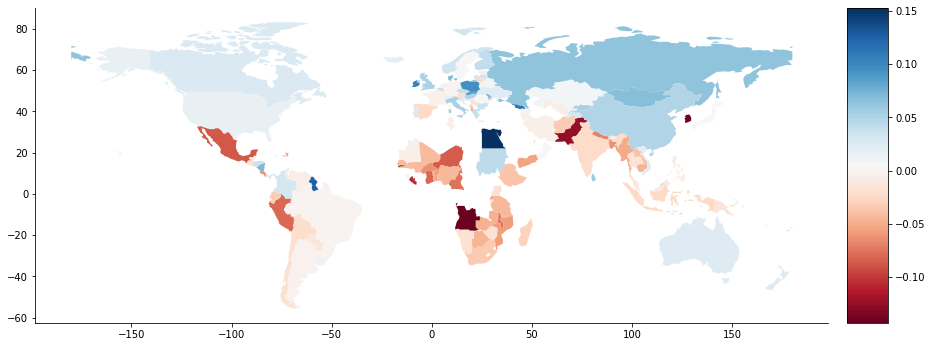

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 15.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world['iso_a3']=='USA','name'] = 'United States'
world.loc[world['iso_a3']=='CHN','name'] = "China"
world.loc[world['iso_a3']=='RUS','name'] = 'Russia'
world.merge(informalidad[(informalidad['diff_male_female']<0.2)&(informalidad['diff_male_female']>-0.15)],left_on='name',right_on='Country').dropna().plot(column='diff_male_female',cmap='RdBu',ax=ax,cax=cax,legend=True)
sns.despine()
plt.savefig(path_tesis + '/Graficas/labor_informality_sex.png')
plt.show()

### Base para la regresión

Para el análisis se utilizará base con corte en el 31 de diciembre del 2020. 

#### Regresión para muertes y casos

In [18]:
# Creamos log muertes y casos por millon

covid_recortada['log_total_cases_per_million'] = np.log(covid_recortada['total_cases_per_million'])
covid_recortada['log_total_deaths_per_million'] = np.log(covid_recortada['total_deaths_per_million'])

# Unión de bases
covid_2 = covid_recortada.merge(covid_income_support_prom,on='Country')
covid_3 = covid_2.merge(covid_debt_relief_prom,on='Country')
covid_4 = covid_3.merge(stay_home_averages,on='Country')
covid_5 = covid_4.merge(globalization,on='Country',how='left')
covid_6 = covid_5.merge(correlations_stay_home,on='Country',how='left')
covid_final = covid_6.merge(informalidad,on='Country')
covid_final['informality_sq'] = covid_final['informality'] ** 2 
covid_final = covid_final.drop_duplicates('Country',keep='first')
covid_final.head()

,Unnamed: 0,iso_code,continent,Country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,correlation_workplace,correlation_residential,Informality,Male informality,Female informality,informality,male_informality,female_informality,diff_male_female,informality_sq
0,311,AFG,Asia,Afghanistan,2020-12-31,52330.0,0.0,139.000,2189.0,0.0,...,-0.674369,0.571033,66.586920,65.504091,68.733666,0.665869,0.655041,0.687337,-0.032296,0.443382
1,1821,ALB,Europe,Albania,2020-12-31,58316.0,589.0,498.429,1181.0,7.0,...,NaN,NaN,61.000000,59.000000,63.500000,0.610000,0.590000,0.635000,-0.045000,0.372100
2,4038,AGO,Africa,Angola,2020-12-31,17553.0,120.0,74.857,405.0,0.0,...,-0.341505,0.666950,84.300000,77.200000,91.300000,0.843000,0.772000,0.913000,-0.141000,0.710649
3,6291,ARG,South America,Argentina,2020-12-31,1625514.0,11586.0,8807.000,43245.0,82.0,...,-0.696981,0.788091,47.200000,47.100000,47.200000,0.472000,0.471000,0.472000,-0.001000,0.222784
4,9356,AUS,Oceania,Australia,2020-12-31,28425.0,20.0,21.571,909.0,0.0,...,-0.535327,0.460879,17.627785,5.035337,2.592678,0.176278,0.050353,0.025927,0.024427,0.031074


In [ ]:
# Bases para las pruebas de robustez - non agricultural informality 

covid_final_nonag = covid_final.merge(informalidad_nonag,on='Country',how='right')
covid_final_nonag['informality_sq'] = covid_final_nonag['inf_na'] ** 2 
covid_final_nonag.head()

In [350]:
# Bases para las pruebas de robustez - excess deaths 


In [348]:
# Bases para el estudio económico

covid_final_economic = covid_final.merge(covid_gdp,on='Country',how='left').merge(comp_econ,on='Country',how='left').merge(covid_gdp,on='Country',how='left')
covid_final_economic_unemp = covid_final.merge(covid_unem,on='Country',how='left').merge(comp_econ,on='Country',how='left').merge(covid_gdp,on='Country',how='left')

In [339]:
covid_final['hospital_beds_per_thousand'].fillna(0,inplace=True)

### Plots presented in the study

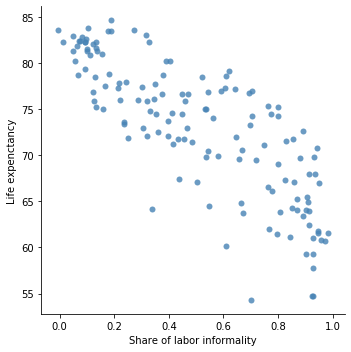

In [20]:
sns.relplot(x='informality',
            y='life_expectancy',
            data=covid_final,
            linewidth=0,
            color="steelblue",
            alpha=0.8)

plt.ylabel('Life expenctancy')
plt.xlabel('Share of labor informality')
plt.savefig(path_tesis + '/Graficas/informality_life_exp.png',bbox_inches='tight')
plt.show()

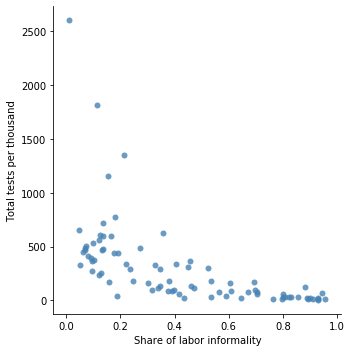

In [47]:
sns.relplot(x='informality',
            y='total_tests_per_thousand',
            data=covid_final,
            linewidth=0,
            color="steelblue",
            alpha=0.8)

plt.ylabel('Total tests per thousand')
plt.xlabel('Share of labor informality')
plt.savefig(path_tesis + '/Graficas/tests_thousand.png',bbox_inches='tight')
plt.show()

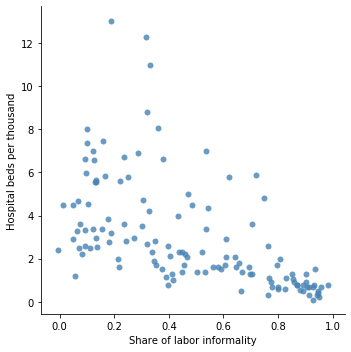

In [48]:
sns.relplot(x='informality',y='hospital_beds_per_thousand',data=covid_final,linewidth=0,color="steelblue",alpha=0.8)
plt.ylabel('Hospital beds per thousand')
plt.xlabel('Share of labor informality')
plt.savefig(path_tesis + '/Graficas/hosp_thousand.png',bbox_inches='tight')
plt.show()

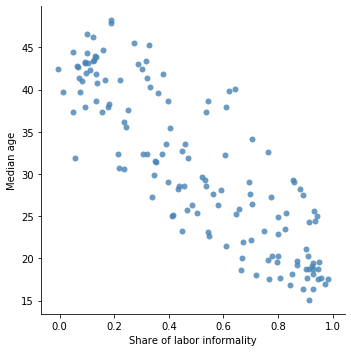

In [49]:
sns.relplot(x='informality',y='median_age',data=covid_final,linewidth=0,color="steelblue",alpha=0.8)
plt.ylabel('Median age')
plt.xlabel('Share of labor informality')
plt.savefig(path_tesis + '/Graficas/informality_median_age.png',bbox_inches='tight')
plt.show()

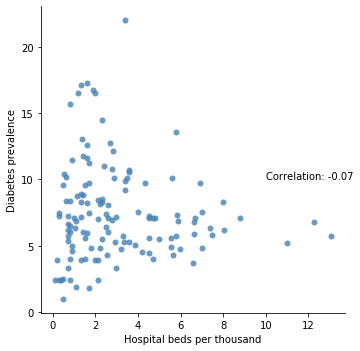

In [50]:
sns.relplot(y='diabetes_prevalence',x='hospital_beds_per_thousand',data=covid_final,linewidth=0,color="steelblue",alpha=0.8)
plt.xlabel('Hospital beds per thousand')
plt.text(x=10,y=10,s='Correlation: {0:.2f}'.format(np.corrcoef(covid_final.dropna(subset=['hospital_beds_per_thousand'])['diabetes_prevalence'],covid_final['hospital_beds_per_thousand'].dropna())[1,0]
))
plt.ylabel('Diabetes prevalence')
plt.savefig(path_tesis + '/Graficas/diabetes_hospital.png',bbox_inches='tight')
plt.show()

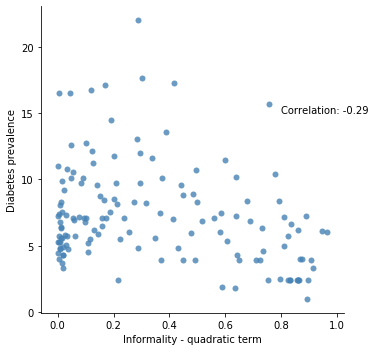

In [51]:
sns.relplot(x='informality_sq',y='diabetes_prevalence',data=covid_final,linewidth=0,color="steelblue",alpha=0.8)
plt.text(x=0.8,y=15,s='Correlation: {0:.2f}'.format(np.corrcoef(covid_final['diabetes_prevalence'],covid_final['informality_sq'])[1,0]))
plt.xlabel('Informality - quadratic term')
plt.ylabel('Diabetes prevalence')
plt.savefig('/users/efrainrodriguez/desktop/diabetes_informality.png',bbox_inches='tight')
plt.show()

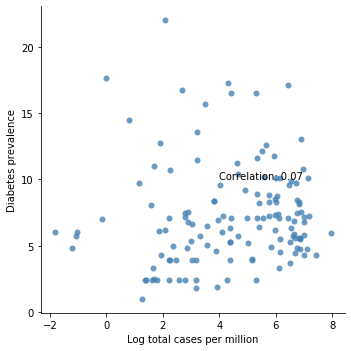

In [340]:
sns.relplot(x='log_total_deaths_per_million',y='diabetes_prevalence',data=covid_final,linewidth=0,color="steelblue",alpha=0.8)
plt.text(x=4,y=10,s='Correlation: {0:.2f}'.format(np.corrcoef(covid_final['diabetes_prevalence'],covid_final['log_total_cases_per_million'])[1,0]))
plt.xlabel('Log total cases per million')
plt.ylabel('Diabetes prevalence')
plt.savefig(path_tesis + '/Graficas/diabetes_cases.png',bbox_inches='tight')
plt.show()

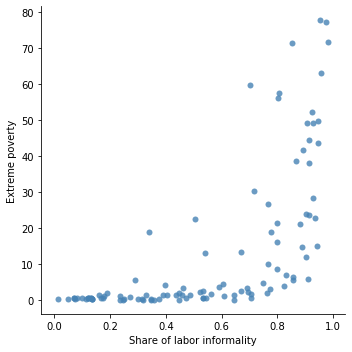

In [53]:
sns.relplot(x='informality',
            y='extreme_poverty',
            color = 'steelblue',
            linewidth = 0,
            alpha = 0.8,
            data=covid_final)
plt.ylabel('Extreme poverty')
plt.xlabel('Share of labor informality')
plt.savefig(path_tesis + '/Graficas/poverty_age.png',bbox_inches='tight')
plt.show()

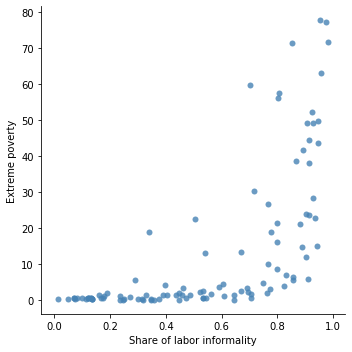

In [54]:
sns.relplot(x='informality',
            y='extreme_poverty',
            color = 'steelblue',
            linewidth = 0,
            alpha = 0.8,
            data=covid_final)
plt.ylabel('Extreme poverty')
plt.xlabel('Share of labor informality')
plt.savefig(path_tesis + '/Graficas/poverty_age.png',bbox_inches='tight')
plt.show()

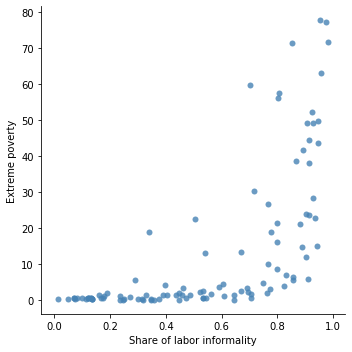

In [55]:
sns.relplot(x='informality',
            y='extreme_poverty',
            color = 'steelblue',
            linewidth = 0,
            alpha = 0.8,
            data=covid_final)
plt.ylabel('Extreme poverty')
plt.xlabel('Share of labor informality')
plt.savefig(path_tesis + '/Graficas/poverty_inf.png',bbox_inches='tight')
plt.show()

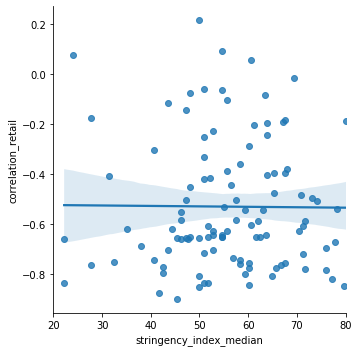

In [338]:
sns.lmplot(x='stringency_index_median',y='correlation_retail',data=covid_final,order=1)
plt.xlim(20,80)
plt.show()

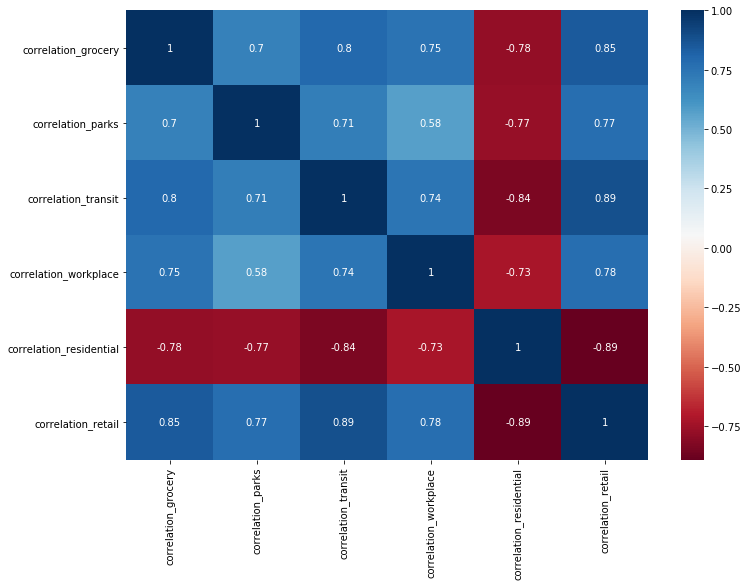

In [68]:
sns.heatmap(covid_final[[
       'correlation_grocery', 'correlation_parks', 'correlation_transit',
       'correlation_workplace', 'correlation_residential','correlation_retail']].corr(),annot=True,cmap='RdBu')
plt.show()

## Statistical analysis

### Correlation analysis

In [157]:
variables_casos = ['Days_pre_pandemic','debt_relief','income_support','population_density',
       'informality','informality_sq','aged_65_older','median_age',             
       'stringency_index_median','string_corr',
       'Depth Score','correlation_retail','total_tests_per_thousand']

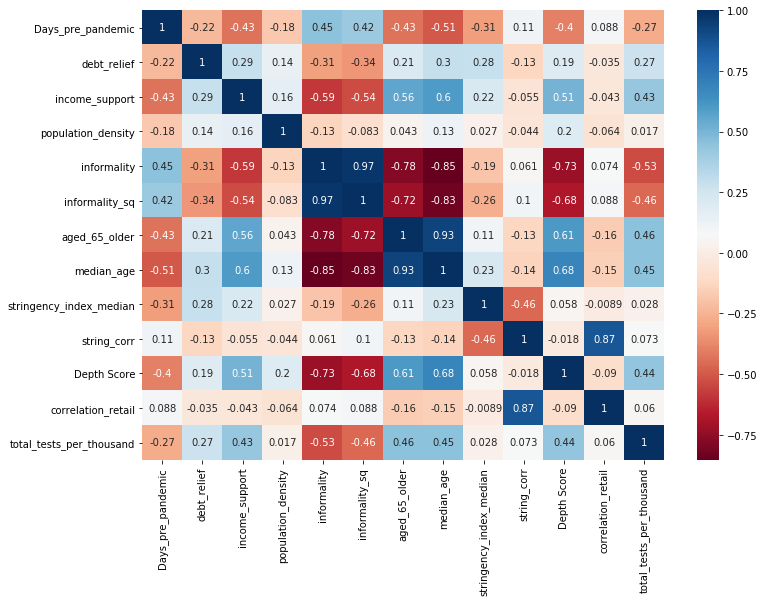

In [158]:
sns.heatmap(covid_final[variables_casos].corr(),cmap='RdBu',annot=True)
plt.show()

### Log Total Cases Per Million Inhabitants

#### Quadratic fit

In [297]:
variables_casos = [
       'Days_pre_pandemic',
       'population_density',
       'informality',
       'informality_sq',
       'aged_65_older',
       'debt_relief',
       'income_support'
     ]

In [300]:
X_1 = covid_final[variables_casos]
X_1 = sm.add_constant(X_1)
y_1 = covid_final['log_total_cases_per_million']

# Agregamos un vector de unos para la constante 

model_1 = sm.OLS(y_1,X_1,missing='drop')
results_1 = model_1.fit()

results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     log_total_cases_per_million   R-squared:                       0.503
Model:                                     OLS   Adj. R-squared:                  0.477
Method:                          Least Squares   F-statistic:                     19.21
Date:                         Sat, 26 Mar 2022   Prob (F-statistic):           1.43e-17
Time:                                 17:12:06   Log-Likelihood:                -266.50
No. Observations:                          141   AIC:                             549.0
Df Residuals:                              133   BIC:                             572.6
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.5215      1.055     10.923      0.000       9.435      13.608
Days_pre_pandemic     -0.0261      0.006     -4.467      0.000      -0.038      -0.015
population_density    -0.0002      0.000     -0.769      0.443      -0.001       0.000
informality           -0.3859      2.474     -0.156      0.876      -5.279       4.507
informality_sq        -3.1015      2.125     -1.460      0.147      -7.305       1.102
aged_65_older          0.0295      0.037      0.804      0.423      -0.043       0.102
debt_relief            0.0467      0.389      0.120      0.905      -0.723       0.816
income_support        -0.3272      0.485     -0.675      0.501      -1.286       0.632
==============================================================================
Omnibus:                       33.867   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.407
Skew:                          -1.232   Prob(JB):                     6.87e-12
Kurtosis:                       4.637   Cond. No.                     1.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Linear fit

In [302]:
model_1_lin = sm.OLS(y_1,X_1.drop('informality_sq',axis=1),missing='drop')
results_1_lin = model_1_lin.fit()
results_1_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     log_total_cases_per_million   R-squared:                       0.495
Model:                                     OLS   Adj. R-squared:                  0.472
Method:                          Least Squares   F-statistic:                     21.87
Date:                         Sat, 26 Mar 2022   Prob (F-statistic):           8.02e-18
Time:                                 17:15:12   Log-Likelihood:                -267.62
No. Observations:                          141   AIC:                             549.2
Df Residuals:                              134   BIC:                             569.9
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.2713      0.925     13.264      0.000      10.442      14.101
Days_pre_pandemic     -0.0259      0.006     -4.406      0.000      -0.037      -0.014
population_density    -0.0002      0.000     -1.166      0.246      -0.001       0.000
informality           -3.8106      0.787     -4.841      0.000      -5.368      -2.254
aged_65_older          0.0161      0.036      0.450      0.653      -0.055       0.087
debt_relief            0.1711      0.381      0.449      0.654      -0.583       0.925
income_support        -0.4238      0.482     -0.879      0.381      -1.378       0.530
==============================================================================
Omnibus:                       28.181   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.480
Skew:                          -1.110   Prob(JB):                     4.41e-09
Kurtosis:                       4.274   Cond. No.                     5.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Quadratic fit with non agricultural informality 

In [303]:
variables_ = [
       'Days_pre_pandemic',
       'population_density',
       'inf_na',
       'informality_sq',
       'aged_65_older',
       'debt_relief',
       'income_support'
     ]

In [370]:
X_ = covid_final_nonag[variables_]
X_ = sm.add_constant(X_)
y_ = covid_final_nonag['log_total_cases_per_million']

# Agregamos un vector de unos para la constante 

model_ = sm.OLS(y_,X_,missing='drop')
results_1_na = model_.fit()
results_1_na.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     log_total_cases_per_million   R-squared:                       0.509
Model:                                     OLS   Adj. R-squared:                  0.482
Method:                          Least Squares   F-statistic:                     18.67
Date:                         Sun, 27 Mar 2022   Prob (F-statistic):           6.65e-17
Time:                                 14:57:55   Log-Likelihood:                -249.99
No. Observations:                          134   AIC:                             516.0
Df Residuals:                              126   BIC:                             539.2
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.5173      1.267      9.089      0.000       9.010      14.025
Days_pre_pandemic     -0.0295      0.006     -4.870      0.000      -0.041      -0.018
population_density    -0.0002      0.000     -0.851      0.396      -0.001       0.000
inf_na                 0.6709      3.150      0.213      0.832      -5.562       6.904
informality_sq        -4.2453      2.736     -1.552      0.123      -9.659       1.168
aged_65_older          0.0323      0.045      0.712      0.478      -0.058       0.122
debt_relief           -0.0278      0.397     -0.070      0.944      -0.814       0.758
income_support        -0.2687      0.482     -0.558      0.578      -1.222       0.685
==============================================================================
Omnibus:                       39.451   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.662
Skew:                          -1.406   Prob(JB):                     3.35e-15
Kurtosis:                       5.009   Cond. No.                     2.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [371]:
X_ = covid_final_nonag[variables_]
X_ = sm.add_constant(X_)
y_ = covid_final_nonag['log_total_cases_per_million']

# Agregamos un vector de unos para la constante 

model_ = sm.OLS(y_,X_.drop('informality_sq',axis=1),missing='drop')
results_1_na_lin = model_.fit()
results_1_na_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     log_total_cases_per_million   R-squared:                       0.500
Model:                                     OLS   Adj. R-squared:                  0.476
Method:                          Least Squares   F-statistic:                     21.14
Date:                         Sun, 27 Mar 2022   Prob (F-statistic):           4.32e-17
Time:                                 14:58:25   Log-Likelihood:                -251.26
No. Observations:                          134   AIC:                             516.5
Df Residuals:                              127   BIC:                             536.8
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.6636      1.035     12.232      0.000      10.615      14.712
Days_pre_pandemic     -0.0295      0.006     -4.839      0.000      -0.042      -0.017
population_density    -0.0002      0.000     -1.210      0.229      -0.001       0.000
inf_na                -3.9488      1.035     -3.815      0.000      -5.997      -1.900
aged_65_older          0.0025      0.041      0.061      0.951      -0.079       0.085
debt_relief            0.1337      0.386      0.347      0.729      -0.629       0.897
income_support        -0.3746      0.479     -0.781      0.436      -1.323       0.574
==============================================================================
Omnibus:                       33.157   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.004
Skew:                          -1.259   Prob(JB):                     1.39e-11
Kurtosis:                       4.617   Cond. No.                     7.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log Total Deaths Per Million Inhabitants 

In [373]:
variables_muertes = variables_casos + ['hospital_beds_per_thousand','cardiovasc_death_rate', 'diabetes_prevalence']

X_3 = covid_final[variables_muertes]
X_3 = sm.add_constant(X_3)
y_3 = covid_final['log_total_deaths_per_million'].copy()

# Agregamos un vector de unos para la constante 

model_3 = sm.OLS(y_3,X_3,missing='drop')
results_2 = model_3.fit()
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     log_total_deaths_per_million   R-squared:                       0.465
Model:                                      OLS   Adj. R-squared:                  0.421
Method:                           Least Squares   F-statistic:                     10.76
Date:                          Sun, 27 Mar 2022   Prob (F-statistic):           5.42e-13
Time:                                  15:02:20   Log-Likelihood:                -252.91
No. Observations:                           135   AIC:                             527.8
Df Residuals:                               124   BIC:                             559.8
Df Model:                                    10                                         
Covariance Type:                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          6.0517      1.244      4.863      0.000       3.589       8.515
Days_pre_pandemic             -0.0218      0.010     -2.123      0.036      -0.042      -0.001
population_density            -0.0005      0.000     -2.192      0.030      -0.001   -4.73e-05
informality                    5.6905      2.637      2.158      0.033       0.471      10.910
informality_sq                -8.1424      2.433     -3.347      0.001     -12.958      -3.327
aged_65_older                  0.1202      0.045      2.698      0.008       0.032       0.208
debt_relief                   -0.4515      0.401     -1.126      0.262      -1.245       0.342
income_support                 0.3503      0.522      0.672      0.503      -0.682       1.383
hospital_beds_per_thousand    -0.2390      0.089     -2.690      0.008      -0.415      -0.063
cardiovasc_death_rate          0.0002      0.001      0.140      0.889      -0.003       0.003
diabetes_prevalence           -0.0467      0.045     -1.041      0.300      -0.135       0.042
==============================================================================
Omnibus:                       24.946   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.761
Skew:                          -1.009   Prob(JB):                     4.66e-08
Kurtosis:                       4.389   Cond. No.                     1.85e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [374]:
X_3 = covid_final[variables_muertes]
X_3 = sm.add_constant(X_3)
y_3 = covid_final['log_total_deaths_per_million']

# Agregamos un vector de unos para la constante 

model_2lin = sm.OLS(y_3,X_3.drop('informality_sq',axis=1),missing='drop')
results_2_lin = model_3lin.fit()
results_2_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     log_total_deaths_per_million   R-squared:                       0.416
Model:                                      OLS   Adj. R-squared:                  0.374
Method:                           Least Squares   F-statistic:                     9.906
Date:                          Sun, 27 Mar 2022   Prob (F-statistic):           2.30e-11
Time:                                  15:02:32   Log-Likelihood:                -258.75
No. Observations:                           135   AIC:                             537.5
Df Residuals:                               125   BIC:                             566.6
Df Model:                                     9                                         
Covariance Type:                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          7.2762      1.237      5.882      0.000       4.828       9.724
Days_pre_pandemic             -0.0249      0.011     -2.339      0.021      -0.046      -0.004
population_density            -0.0007      0.000     -3.260      0.001      -0.001      -0.000
informality                   -2.6189      0.925     -2.832      0.005      -4.449      -0.789
aged_65_older                  0.0859      0.045      1.906      0.059      -0.003       0.175
debt_relief                   -0.1963      0.409     -0.480      0.632      -1.007       0.614
income_support                 0.1409      0.539      0.262      0.794      -0.925       1.207
hospital_beds_per_thousand    -0.1656      0.090     -1.850      0.067      -0.343       0.012
cardiovasc_death_rate          0.0005      0.001      0.360      0.720      -0.002       0.003
diabetes_prevalence            0.0109      0.043      0.252      0.801      -0.074       0.096
==============================================================================
Omnibus:                       14.730   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.054
Skew:                          -0.779   Prob(JB):                     0.000327
Kurtosis:                       3.653   Cond. No.                     6.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [375]:
variables_muertes_ = variables_ + ['hospital_beds_per_thousand','cardiovasc_death_rate', 'diabetes_prevalence']

In [376]:
X_ = covid_final_nonag[variables_muertes_]
X_ = sm.add_constant(X_)
y_ = covid_final_nonag['log_total_deaths_per_million']

# Agregamos un vector de unos para la constante 

model_ = sm.OLS(y_,X_,missing='drop')
results_2_na = model_.fit()
results_2_na.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     log_total_deaths_per_million   R-squared:                       0.459
Model:                                      OLS   Adj. R-squared:                  0.413
Method:                           Least Squares   F-statistic:                     10.01
Date:                          Sun, 27 Mar 2022   Prob (F-statistic):           5.21e-12
Time:                                  15:04:17   Log-Likelihood:                -242.57
No. Observations:                           129   AIC:                             507.1
Df Residuals:                               118   BIC:                             538.6
Df Model:                                    10                                         
Covariance Type:                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          5.8998      1.503      3.925      0.000       2.923       8.876
Days_pre_pandemic             -0.0389      0.012     -3.129      0.002      -0.064      -0.014
population_density            -0.0006      0.000     -2.661      0.009      -0.001      -0.000
inf_na                         7.1414      3.390      2.106      0.037       0.428      13.855
informality_sq                -8.6520      3.185     -2.716      0.008     -14.960      -2.344
aged_65_older                  0.1553      0.053      2.935      0.004       0.051       0.260
debt_relief                   -0.5056      0.418     -1.209      0.229      -1.334       0.323
income_support                 0.3179      0.536      0.594      0.554      -0.743       1.378
hospital_beds_per_thousand    -0.2146      0.091     -2.363      0.020      -0.394      -0.035
cardiovasc_death_rate          0.0010      0.001      0.713      0.477      -0.002       0.004
diabetes_prevalence           -0.0115      0.047     -0.246      0.806      -0.104       0.081
==============================================================================
Omnibus:                       28.032   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.296
Skew:                          -1.096   Prob(JB):                     1.08e-09
Kurtosis:                       4.697   Cond. No.                     2.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [377]:
X_ = covid_final_nonag[variables_muertes_]
X_ = sm.add_constant(X_)
y_ = covid_final_nonag['log_total_deaths_per_million']

# Agregamos un vector de unos para la constante 

model_lin = sm.OLS(y_,X_.drop('informality_sq',axis=1),missing='drop')
results_2_na_lin = model_lin.fit()
results_2_na_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     log_total_deaths_per_million   R-squared:                       0.425
Model:                                      OLS   Adj. R-squared:                  0.382
Method:                           Least Squares   F-statistic:                     9.779
Date:                          Sun, 27 Mar 2022   Prob (F-statistic):           4.26e-11
Time:                                  15:05:50   Log-Likelihood:                -246.48
No. Observations:                           129   AIC:                             513.0
Df Residuals:                               119   BIC:                             541.6
Df Model:                                     9                                         
Covariance Type:                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          7.6660      1.391      5.511      0.000       4.912      10.420
Days_pre_pandemic             -0.0442      0.013     -3.506      0.001      -0.069      -0.019
population_density            -0.0008      0.000     -3.498      0.001      -0.001      -0.000
inf_na                        -1.4120      1.289     -1.095      0.276      -3.965       1.141
aged_65_older                  0.1032      0.051      2.039      0.044       0.003       0.203
debt_relief                   -0.2584      0.419     -0.616      0.539      -1.088       0.572
income_support                 0.1254      0.545      0.230      0.818      -0.954       1.204
hospital_beds_per_thousand    -0.1561      0.091     -1.724      0.087      -0.335       0.023
cardiovasc_death_rate          0.0010      0.001      0.719      0.474      -0.002       0.004
diabetes_prevalence            0.0389      0.044      0.881      0.380      -0.049       0.126
==============================================================================
Omnibus:                       16.839   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.161
Skew:                          -0.851   Prob(JB):                     6.90e-05
Kurtosis:                       3.818   Cond. No.                     8.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [378]:
# Excess deaths 

covid_excessdeaths = covid_final.merge(excess_cumul,left_on='iso_code',right_on='iso3c')

X_ = covid_excessdeaths[variables_muertes]
X_ = sm.add_constant(X_)
y_ = covid_excessdeaths['cumulative_estimated_daily_excess_deaths_per_100k']

# Agregamos un vector de unos para la constante 

model_ = sm.OLS(y_,X_,missing='drop')
results_3 = model_.fit()
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     cumulative_estimated_daily_excess_deaths_per_100k   R-squared:                       0.190
Model:                                                           OLS   Adj. R-squared:                  0.127
Method:                                                Least Squares   F-statistic:                     3.042
Date:                                               Sun, 27 Mar 2022   Prob (F-statistic):            0.00171
Time:                                                       15:06:19   Log-Likelihood:                -808.58
No. Observations:                                                141   AIC:                             1639.
Df Residuals:                                                    130   BIC:                             1672.
Df Model:                                                         10                                         
Covariance Type:                                           nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -25.0849     52.684     -0.476      0.635    -129.314      79.144
Days_pre_pandemic             -0.5052      0.294     -1.718      0.088      -1.087       0.077
population_density            -0.0034      0.010     -0.328      0.744      -0.024       0.017
informality                  285.1889    124.557      2.290      0.024      38.767     531.610
informality_sq              -228.3423    113.671     -2.009      0.047    -453.228      -3.457
aged_65_older                  6.6363      2.062      3.218      0.002       2.556      10.717
debt_relief                  -31.8746     18.660     -1.708      0.090     -68.792       5.042
income_support                -7.0262     23.531     -0.299      0.766     -53.579      39.527
hospital_beds_per_thousand    -0.6860      4.101     -0.167      0.867      -8.799       7.427
cardiovasc_death_rate          0.1257      0.065      1.931      0.056      -0.003       0.254
diabetes_prevalence            0.0081      2.124      0.004      0.997      -4.195       4.211
==============================================================================
Omnibus:                        6.883   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.777
Skew:                           0.420   Prob(JB):                       0.0338
Kurtosis:                       3.669   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [379]:
covid_excessdeaths = covid_final.merge(excess_cumul,left_on='iso_code',right_on='iso3c')

X_ = covid_excessdeaths[variables_muertes]
X_ = sm.add_constant(X_)
y_ = covid_excessdeaths['cumulative_estimated_daily_excess_deaths_per_100k']

# Agregamos un vector de unos para la constante 

model_lin = sm.OLS(y_,X_.drop('informality_sq',axis=1),missing='drop')
results_3_lin = model_lin.fit()
results_3_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     cumulative_estimated_daily_excess_deaths_per_100k   R-squared:                       0.164
Model:                                                           OLS   Adj. R-squared:                  0.107
Method:                                                Least Squares   F-statistic:                     2.865
Date:                                               Sun, 27 Mar 2022   Prob (F-statistic):            0.00407
Time:                                                       15:06:31   Log-Likelihood:                -810.74
No. Observations:                                                141   AIC:                             1641.
Df Residuals:                                                    131   BIC:                             1671.
Df Model:                                                          9                                         
Covariance Type:                                           nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          5.4875     51.019      0.108      0.915     -95.440     106.415
Days_pre_pandemic             -0.5078      0.297     -1.707      0.090      -1.096       0.081
population_density            -0.0097      0.010     -0.960      0.339      -0.030       0.010
informality                   48.0088     40.127      1.196      0.234     -31.373     127.390
aged_65_older                  5.6467      2.026      2.787      0.006       1.639       9.654
debt_relief                  -24.1938     18.475     -1.310      0.193     -60.741      12.353
income_support               -13.6959     23.564     -0.581      0.562     -60.310      32.919
hospital_beds_per_thousand     1.4487      4.006      0.362      0.718      -6.477       9.374
cardiovasc_death_rate          0.1315      0.066      1.999      0.048       0.001       0.262
diabetes_prevalence            1.6653      1.980      0.841      0.402      -2.252       5.582
==============================================================================
Omnibus:                       10.818   Durbin-Watson:                   2.313
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.668
Skew:                           0.560   Prob(JB):                      0.00293
Kurtosis:                       3.855   Cond. No.                     6.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Economic regressions 

In [380]:
variables_infor = [
       'informality','informality_sq'
       ]

X_info = covid_final[variables_infor]
X_info = sm.add_constant(X_info)
y_info = covid_final['log_total_deaths_per_million']

# Agregamos un vector de unos para la constante 

model_info = sm.OLS(y_info,X_info,missing='drop')
results_info = model_info.fit()

covid_final['unos'] = 1 

covid_final['log_deaths_predicted'] = results_info.predict(covid_final[variables_infor+['unos']])
covid_final['resid_log_deaths'] = covid_final['log_total_deaths_per_million'] - covid_final['log_deaths_predicted']

In [381]:
model_info = sm.OLS(y_info,X_info,missing='drop')
results_info = model_info.fit()
results_info.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     log_total_deaths_per_million   R-squared:                       0.348
Model:                                      OLS   Adj. R-squared:                  0.339
Method:                           Least Squares   F-statistic:                     35.30
Date:                          Sun, 27 Mar 2022   Prob (F-statistic):           5.26e-13
Time:                                  15:08:55   Log-Likelihood:                -266.18
No. Observations:                           135   AIC:                             538.4
Df Residuals:                               132   BIC:                             547.1
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6036      0.449     12.486      0.000       4.716       6.491
informality        1.1002      2.180      0.505      0.615      -3.211       5.412
informality_sq    -5.0738      2.104     -2.411      0.017      -9.237      -0.911
==============================================================================
Omnibus:                       22.459   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.252
Skew:                          -0.977   Prob(JB):                     7.33e-07
Kurtosis:                       4.096   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [382]:
covid_spending = pd.read_excel(path_tesis+'/Bases/covidspending.xlsx')
covid_spending.head()

,Country,Additional spending or foregone revenues
0,Australia,16.177852
1,Canada,14.646142
2,European Union,3.804947
3,France,7.710301
4,Germany,11.033705


In [383]:
covid_econ = covid_final_economic.merge(covid_spending,left_on='Country',right_on='Country ')

In [420]:
vars_interes = ['unos','resid_log_deaths','Additional spending or foregone revenues',
       'Services',
       'Depth Score',                   
        'informality','informality_sq']

target = ['Real GDP growth (Annual percent change)_x']
                                                                  
X = covid_econ[vars_interes]
y = covid_econ[target].rename(columns={'Real GDP growth (Annual percent change)_x':'Real GDP growth (Annual percent change)'})

In [421]:
# Agregamos un vector de unos para la constante 

## Cuidado con esto porque para 2020 completo hay algunos paises que solo tengan pronosticos -> contrastar con The Economist
## Revisar 

X = sm.add_constant(X)
model = sm.OLS(y,X,missing='drop')
results_4 = model.fit()
results_4.summary()

## Siempre hacer gráficas, variable de interés 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Real GDP growth (Annual percent change)   R-squared:                       0.324
Model:                                                 OLS   Adj. R-squared:                  0.289
Method:                                      Least Squares   F-statistic:                     9.120
Date:                                     Sun, 27 Mar 2022   Prob (F-statistic):           3.81e-08
Time:                                             15:24:24   Log-Likelihood:                -334.54
No. Observations:                                      121   AIC:                             683.1
Df Residuals:                                          114   BIC:                             702.7
Df Model:                                                6                                         
Covariance Type:                                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                        16.3576      4.033      4.055      0.000       8.367      24.348
resid_log_deaths                            -0.3601      0.221     -1.629      0.106      -0.798       0.078
Additional spending or foregone revenues    -0.0963      0.116     -0.830      0.409      -0.326       0.134
Services                                   -12.7679      4.274     -2.987      0.003     -21.235      -4.300
Depth Score                                 -0.1434      0.054     -2.640      0.009      -0.251      -0.036
informality                                -29.2826      5.969     -4.906      0.000     -41.107     -17.458
informality_sq                              21.8686      5.429      4.028      0.000      11.113      32.624
==============================================================================
Omnibus:                        5.776   Durbin-Watson:                   2.601
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.478
Skew:                          -0.395   Prob(JB):                       0.0646
Kurtosis:                       3.679   Cond. No.                         619.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [422]:
X = sm.add_constant(X)
model_lin = sm.OLS(y,X.drop('informality_sq',axis=1),missing='drop')
results_4_lin = model_lin.fit()
results_4_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Real GDP growth (Annual percent change)   R-squared:                       0.228
Model:                                                 OLS   Adj. R-squared:                  0.195
Method:                                      Least Squares   F-statistic:                     6.799
Date:                                     Sun, 27 Mar 2022   Prob (F-statistic):           1.37e-05
Time:                                             15:24:29   Log-Likelihood:                -342.59
No. Observations:                                      121   AIC:                             697.2
Df Residuals:                                          115   BIC:                             714.0
Df Model:                                                5                                         
Covariance Type:                                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                        14.7961      4.272      3.463      0.001       6.334      23.259
resid_log_deaths                            -0.5721      0.228     -2.504      0.014      -1.025      -0.120
Additional spending or foregone revenues    -0.0455      0.123     -0.371      0.712      -0.289       0.198
Services                                   -14.3079      4.530     -3.158      0.002     -23.281      -5.334
Depth Score                                 -0.1077      0.057     -1.889      0.061      -0.221       0.005
informality                                 -8.8277      3.338     -2.645      0.009     -15.439      -2.217
==============================================================================
Omnibus:                       14.630   Durbin-Watson:                   2.606
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.497
Skew:                          -0.715   Prob(JB):                     0.000159
Kurtosis:                       4.194   Cond. No.                         415.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [388]:
covid_econ_na = covid_final_nonag.merge(covid_gdp,on='Country',how='left').merge(covid_spending,left_on='Country',right_on='Country ').merge(comp_econ,on='Country')

In [389]:
variables_infor = [
       'inf_na','informality_sq'
       ]

X_info = covid_final_nonag[variables_infor]
X_info = sm.add_constant(X_info)
y_info = covid_final_nonag['log_total_deaths_per_million']
covid_econ_na['unos'] = 1 

# Agregamos un vector de unos para la constante 

model_info = sm.OLS(y_info,X_info,missing='drop')
results_info = model_info.fit()


covid_econ_na['log_deaths_predicted'] = results_info.predict(covid_econ_na[variables_infor+['unos']])
covid_econ_na['resid_log_deaths'] = covid_econ_na['log_total_deaths_per_million'] - covid_econ_na['log_deaths_predicted']

In [390]:
vars_interes = ['unos','resid_log_deaths','Additional spending or foregone revenues','Services',
        'inf_na','informality_sq','Depth Score']

target = ['Real GDP growth (Annual percent change)']
                                                                  
X_na = covid_econ_na[vars_interes]
y_na = covid_econ_na[target]

In [391]:

# Agregamos un vector de unos para la constante 

model_na = sm.OLS(y_na,X_na,missing='drop')
results_4_na = model_na.fit()
results_4_na.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Real GDP growth (Annual percent change)   R-squared:                       0.347
Model:                                                 OLS   Adj. R-squared:                  0.312
Method:                                      Least Squares   F-statistic:                     9.836
Date:                                     Sun, 27 Mar 2022   Prob (F-statistic):           1.11e-08
Time:                                             15:10:04   Log-Likelihood:                -321.05
No. Observations:                                      118   AIC:                             656.1
Df Residuals:                                          111   BIC:                             675.5
Df Model:                                                6                                         
Covariance Type:                                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                        13.9627      4.044      3.452      0.001       5.949      21.977
resid_log_deaths                            -0.2066      0.208     -0.994      0.322      -0.618       0.205
Additional spending or foregone revenues    -0.0782      0.111     -0.702      0.484      -0.299       0.143
Services                                   -13.8135      4.217     -3.276      0.001     -22.170      -5.457
inf_na                                     -31.2843      6.359     -4.919      0.000     -43.886     -18.683
informality_sq                              28.6343      6.122      4.678      0.000      16.504      40.765
Depth Score                                 -0.1061      0.053     -1.985      0.050      -0.212      -0.000
==============================================================================
Omnibus:                        4.033   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                3.671
Skew:                          -0.285   Prob(JB):                        0.160
Kurtosis:                       3.650   Cond. No.                         706.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [392]:
vars_interes = ['unos','resid_log_deaths','Additional spending or foregone revenues',
       'Services',
        'Depth Score',
        'inf_na']

target = ['Real GDP growth (Annual percent change)']
                                                                  
X_na_lin = covid_econ_na[vars_interes]
y_na_lin = covid_econ_na[target]

In [393]:

# Agregamos un vector de unos para la constante 

model_na_lin = sm.OLS(y_na_lin,X_na_lin,missing='drop')
results_4_na_lin = model_na_lin.fit()
results_4_na_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Real GDP growth (Annual percent change)   R-squared:                       0.218
Model:                                                 OLS   Adj. R-squared:                  0.184
Method:                                      Least Squares   F-statistic:                     6.260
Date:                                     Sun, 27 Mar 2022   Prob (F-statistic):           3.70e-05
Time:                                             15:10:14   Log-Likelihood:                -331.66
No. Observations:                                      118   AIC:                             675.3
Df Residuals:                                          112   BIC:                             691.9
Df Model:                                                5                                         
Covariance Type:                                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                        11.3573      4.363      2.603      0.010       2.712      20.002
resid_log_deaths                            -0.3466      0.224     -1.547      0.125      -0.790       0.097
Additional spending or foregone revenues    -0.0153      0.120     -0.127      0.899      -0.254       0.223
Services                                   -15.4201      4.578     -3.368      0.001     -24.491      -6.350
Depth Score                                 -0.0804      0.058     -1.387      0.168      -0.195       0.034
inf_na                                      -5.3613      3.397     -1.578      0.117     -12.092       1.370
==============================================================================
Omnibus:                       10.873   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.927
Skew:                          -0.599   Prob(JB):                      0.00257
Kurtosis:                       3.994   Cond. No.                         441.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [394]:
covid_econ_ed = covid_excessdeaths.merge(covid_spending,left_on='Country',right_on='Country ').merge(comp_econ,on='Country').merge(covid_gdp,on='Country',how='left')

variables_infor = [
       'informality','informality_sq'
       ]

X_info = covid_econ_ed[variables_infor]
X_info = sm.add_constant(X_info)
y_info = covid_econ_ed['cumulative_estimated_daily_excess_deaths_per_100k']

# Agregamos un vector de unos para la constante 

model_info = sm.OLS(y_info,X_info,missing='drop')
results_info = model_info.fit()

covid_econ_ed['unos'] = 1 

covid_econ_ed['log_deaths_predicted'] = results_info.predict(covid_econ_ed[variables_infor+['unos']])
covid_econ_ed['resid_excess_deaths'] = covid_econ_ed['cumulative_estimated_daily_excess_deaths_per_100k'] - covid_econ_ed['log_deaths_predicted']

In [395]:
vars_interes = ['unos','resid_excess_deaths','Additional spending or foregone revenues',
       'Services','Depth Score',
        'informality','informality_sq']

target = ['Real GDP growth (Annual percent change)']
                                                                  
X_na_ = covid_econ_ed[vars_interes]
y_na_ = covid_econ_ed[target]

model_na_ = sm.OLS(y_na_,X_na_,missing='drop')
results_5 = model_na_.fit()
results_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Real GDP growth (Annual percent change)   R-squared:                       0.328
Model:                                                 OLS   Adj. R-squared:                  0.293
Method:                                      Least Squares   F-statistic:                     9.500
Date:                                     Sun, 27 Mar 2022   Prob (F-statistic):           1.71e-08
Time:                                             15:10:59   Log-Likelihood:                -343.15
No. Observations:                                      124   AIC:                             700.3
Df Residuals:                                          117   BIC:                             720.0
Df Model:                                                6                                         
Covariance Type:                                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                        14.5029      3.776      3.840      0.000       7.024      21.982
resid_excess_deaths                         -0.0027      0.005     -0.591      0.556      -0.012       0.006
Additional spending or foregone revenues    -0.0576      0.113     -0.510      0.611      -0.281       0.166
Services                                   -15.1554      4.185     -3.622      0.000     -23.443      -6.868
Depth Score                                 -0.1481      0.052     -2.864      0.005      -0.251      -0.046
informality                                -27.9497      5.843     -4.783      0.000     -39.522     -16.378
informality_sq                              23.4475      5.417      4.328      0.000      12.719      34.176
==============================================================================
Omnibus:                        4.938   Durbin-Watson:                   2.544
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.520
Skew:                          -0.357   Prob(JB):                        0.104
Kurtosis:                       3.604   Cond. No.                     4.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [396]:
vars_interes = ['unos','resid_excess_deaths','Additional spending or foregone revenues',
       'Services', 'Depth Score',
        'informality']


target = ['Real GDP growth (Annual percent change)']
    
X_na_l = covid_econ_ed[vars_interes]
y_na_l = covid_econ_ed[target]

model_na_l = sm.OLS(y_na_l,X_na_l,missing='drop')
results_5_lin = model_na_l.fit()
results_5_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Real GDP growth (Annual percent change)   R-squared:                       0.220
Model:                                                 OLS   Adj. R-squared:                  0.187
Method:                                      Least Squares   F-statistic:                     6.654
Date:                                     Sun, 27 Mar 2022   Prob (F-statistic):           1.71e-05
Time:                                             15:11:12   Log-Likelihood:                -352.36
No. Observations:                                      124   AIC:                             716.7
Df Residuals:                                          118   BIC:                             733.6
Df Model:                                                5                                         
Covariance Type:                                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                        12.4590      4.019      3.100      0.002       4.501      20.417
resid_excess_deaths                         -0.0077      0.005     -1.624      0.107      -0.017       0.002
Additional spending or foregone revenues     0.0133      0.120      0.111      0.912      -0.224       0.250
Services                                   -18.7324      4.400     -4.258      0.000     -27.445     -10.020
Depth Score                                 -0.1059      0.054     -1.944      0.054      -0.214       0.002
informality                                 -4.8190      2.534     -1.902      0.060      -9.837       0.199
==============================================================================
Omnibus:                       11.689   Durbin-Watson:                   2.523
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.318
Skew:                          -0.665   Prob(JB):                      0.00211
Kurtosis:                       3.784   Cond. No.                     2.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [397]:
covid_econ_unem = covid_final_economic_unemp.merge(covid_spending,left_on='Country',right_on='Country ').merge(comp_econ,on='Country')

In [398]:
vars_interes = ['unos','resid_log_deaths','Additional spending or foregone revenues',
       'Services_x','Depth Score',
        'informality','informality_sq']

target = ['Change_gdp']
                                                                  
X = covid_econ_unem[vars_interes]
y = covid_econ_unem[target]

X = sm.add_constant(X)
model = sm.OLS(y,X,missing='drop')
results_6 = model.fit()
results_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Change_gdp   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     4.038
Date:                Sun, 27 Mar 2022   Prob (F-statistic):            0.00107
Time:                        15:11:22   Log-Likelihood:                -331.25
No. Observations:                 117   AIC:                             676.5
Df Residuals:                     110   BIC:                             695.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                         8.7380      4.332      2.017      0.046       0.153      17.323
resid_log_deaths                            -0.2004      0.237     -0.847      0.399      -0.670       0.269
Additional spending or foregone revenues    -0.0582      0.125     -0.466      0.642      -0.306       0.189
Services_x                                  -8.5906      4.607     -1.865      0.065     -17.721       0.540
Depth Score                                 -0.1340      0.059     -2.283      0.024      -0.250      -0.018
informality                                -24.6500      6.454     -3.819      0.000     -37.441     -11.859
informality_sq                              18.2150      5.874      3.101      0.002       6.573      29.857
==============================================================================
Omnibus:                       12.128   Durbin-Watson:                   2.565
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               33.282
Skew:                           0.160   Prob(JB):                     5.93e-08
Kurtosis:                       5.593   Cond. No.                         614.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [399]:
vars_interes = ['unos','resid_log_deaths','Additional spending or foregone revenues',
       'Services_x','Depth Score',
        'informality','informality_sq']

target = ['Change_gdp']
                                                                  
X = covid_econ_unem[vars_interes]
y = covid_econ_unem[target]

X = sm.add_constant(X)
model_lin = sm.OLS(y,X.drop(columns=['informality_sq']),missing='drop')
results_6_lin = model_lin.fit()
results_6_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Change_gdp   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.712
Date:                Sun, 27 Mar 2022   Prob (F-statistic):             0.0237
Time:                        15:11:29   Log-Likelihood:                -336.15
No. Observations:                 117   AIC:                             684.3
Df Residuals:                     111   BIC:                             700.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
unos                                         7.5104      4.478      1.677      0.096      -1.364      16.384
resid_log_deaths                            -0.3678      0.239     -1.537      0.127      -0.842       0.106
Additional spending or foregone revenues    -0.0131      0.129     -0.102      0.919      -0.268       0.242
Services_x                                 -10.0460      4.758     -2.111      0.037     -19.474      -0.618
Depth Score                                 -0.1059      0.060     -1.759      0.081      -0.225       0.013
informality                                 -7.5810      3.498     -2.168      0.032     -14.512      -0.650
==============================================================================
Omnibus:                       10.757   Durbin-Watson:                   2.517
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               24.798
Skew:                          -0.202   Prob(JB):                     4.12e-06
Kurtosis:                       5.219   Cond. No.                         410.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [400]:
covid_econ_unem_na = covid_econ_na.merge(covid_econ_unem,on='Country')

In [401]:
vars_interes = ['unos_x','resid_log_deaths_x','Additional spending or foregone revenues_x',
       'Services_x',
        'Depth Score_x',
        'inf_na','informality_sq_x']

target = ['Change_gdp']
                                                                  
X = covid_econ_unem_na[vars_interes]
y = covid_econ_unem_na[target]

X = sm.add_constant(X)
model_na = sm.OLS(y,X,missing='drop')
results_6_na = model_na.fit()
results_6_na.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Change_gdp   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3.654
Date:                Sun, 27 Mar 2022   Prob (F-statistic):            0.00244
Time:                        15:11:47   Log-Likelihood:                -319.22
No. Observations:                 114   AIC:                             652.4
Df Residuals:                     107   BIC:                             671.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
unos_x                                         6.7908      4.399      1.544      0.126      -1.929      15.510
resid_log_deaths_x                            -0.0827      0.226     -0.367      0.715      -0.530       0.365
Additional spending or foregone revenues_x    -0.0459      0.121     -0.378      0.706      -0.287       0.195
Services_x                                    -9.7776      4.609     -2.121      0.036     -18.915      -0.641
Depth Score_x                                 -0.1087      0.059     -1.856      0.066      -0.225       0.007
inf_na                                       -22.8978      6.969     -3.286      0.001     -36.714      -9.082
informality_sq_x                              19.8032      6.733      2.941      0.004       6.456      33.150
==============================================================================
Omnibus:                       15.819   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.897
Skew:                           0.494   Prob(JB):                     2.64e-08
Kurtosis:                       5.524   Cond. No.                         702.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [402]:
vars_interes = ['unos_x','resid_log_deaths_x','Additional spending or foregone revenues_x',
       'Services_x',
        'Depth Score_x',
        'inf_na','informality_sq_x']

target = ['Change_gdp']
                                                                  
X = covid_econ_unem_na[vars_interes]
y = covid_econ_unem_na[target]

X = sm.add_constant(X)
model_lin_na = sm.OLS(y,X.drop(columns=['informality_sq_x']),missing='drop')
results_6_na_lin = model_lin_na.fit()
results_6_na_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Change_gdp   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.479
Date:                Sun, 27 Mar 2022   Prob (F-statistic):             0.0363
Time:                        15:12:56   Log-Likelihood:                -323.65
No. Observations:                 114   AIC:                             659.3
Df Residuals:                     108   BIC:                             675.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
unos_x                                         5.1210      4.514      1.135      0.259      -3.826      14.068
resid_log_deaths_x                            -0.1712      0.231     -0.740      0.461      -0.630       0.287
Additional spending or foregone revenues_x    -0.0008      0.125     -0.006      0.995      -0.248       0.246
Services_x                                   -11.0658      4.748     -2.331      0.022     -20.477      -1.654
Depth Score_x                                 -0.0933      0.060     -1.545      0.125      -0.213       0.026
inf_na                                        -4.9884      3.509     -1.422      0.158     -11.943       1.966
==============================================================================
Omnibus:                        7.804   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               15.025
Skew:                           0.089   Prob(JB):                     0.000546
Kurtosis:                       4.770   Cond. No.                         436.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [403]:
covid_econ_unem_ed = covid_econ_ed.merge(covid_econ_unem,on='Country')

In [409]:
vars_interes = ['unos_x','resid_excess_deaths','Additional spending or foregone revenues_x',
       'Services_x',
       'Depth Score_x',
        'informality_x','informality_sq_x']

target = ['Change_gdp']
    
X_na_unem = covid_econ_unem_ed [vars_interes]
y_na_unem = covid_econ_unem_ed [target]

model_na_unem = sm.OLS(y_na_unem,X_na_unem,missing='drop')
results_7_na = model_na_unem.fit()
results_7_na.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Change_gdp   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     4.313
Date:                Sun, 27 Mar 2022   Prob (F-statistic):           0.000596
Time:                        15:15:11   Log-Likelihood:                -337.16
No. Observations:                 119   AIC:                             688.3
Df Residuals:                     112   BIC:                             707.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
unos_x                                         7.8763      4.041      1.949      0.054      -0.130      15.883
resid_excess_deaths                           -0.0005      0.005     -0.091      0.927      -0.010       0.009
Additional spending or foregone revenues_x    -0.0376      0.121     -0.309      0.758      -0.278       0.203
Services_x                                    -9.7493      4.499     -2.167      0.032     -18.664      -0.835
Depth Score_x                                 -0.1510      0.056     -2.702      0.008      -0.262      -0.040
informality_x                                -24.2672      6.324     -3.837      0.000     -36.798     -11.736
informality_sq_x                              19.3011      5.886      3.279      0.001       7.638      30.964
==============================================================================
Omnibus:                       11.120   Durbin-Watson:                   2.534
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.597
Skew:                           0.126   Prob(JB):                     6.17e-07
Kurtosis:                       5.388   Cond. No.                     4.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [410]:
vars_interes = ['unos_x','resid_excess_deaths','Additional spending or foregone revenues_x',
       'Services_x',
       'Depth Score_x',
        'informality_x','informality_sq_x']

target = ['Change_gdp']
    
X_na_unem = covid_econ_unem_ed [vars_interes]
y_na_unem = covid_econ_unem_ed [target]

model_na_unem = sm.OLS(y_na_unem,X_na_unem.drop('informality_sq_x',axis=1),missing='drop')
results_7_na_lin = model_na_unem.fit()
results_7_na_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Change_gdp   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.785
Date:                Sun, 27 Mar 2022   Prob (F-statistic):             0.0207
Time:                        15:15:18   Log-Likelihood:                -342.62
No. Observations:                 119   AIC:                             697.2
Df Residuals:                     113   BIC:                             713.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
unos_x                                         6.2651      4.181      1.499      0.137      -2.017      14.547
resid_excess_deaths                           -0.0044      0.005     -0.864      0.390      -0.014       0.006
Additional spending or foregone revenues_x     0.0255      0.125      0.204      0.839      -0.222       0.273
Services_x                                   -12.7497      4.591     -2.777      0.006     -21.846      -3.653
Depth Score_x                                 -0.1188      0.057     -2.072      0.041      -0.232      -0.005
informality_x                                 -5.2689      2.642     -1.994      0.049     -10.504      -0.034
==============================================================================
Omnibus:                        9.061   Durbin-Watson:                   2.465
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               17.959
Skew:                          -0.185   Prob(JB):                     0.000126
Kurtosis:                       4.867   Cond. No.                     2.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Table formatting for document exportation

In [411]:
from stargazer.stargazer import Stargazer 

stargazer = Stargazer([results_1,results_1_lin,results_1_na,results_1_na_lin])

print(stargazer.render_html())

<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Days_pre_pandemic</td><td>-0.026<sup>***</sup></td><td>-0.026<sup>***</sup></td><td>-0.029<sup>***</sup></td><td>-0.029<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.006)</td><td>(0.006)</td><td>(0.006)</td><td>(0.006)</td></tr><tr><td style="text-align:left">aged_65_older</td><td>0.03<sup></sup></td><td>0.016<sup></sup></td><td>0.032<sup></sup></td><td>0.003<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.037)</td><td>(0.036)</td><td>(0.045)</td><td>(0.041)</td></tr><tr><td style="text-align:left">const</td><td>11.522<sup>***</sup></td

<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Days_pre_pandemic</td><td>-0.026<sup>***</sup></td><td>-0.026<sup>***</sup></td><td>-0.029<sup>***</sup></td><td>-0.029<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.006)</td><td>(0.006)</td><td>(0.006)</td><td>(0.006)</td></tr><tr><td style="text-align:left">aged_65_older</td><td>0.03<sup></sup></td><td>0.016<sup></sup></td><td>0.032<sup></sup></td><td>0.003<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.037)</td><td>(0.036)</td><td>(0.045)</td><td>(0.041)</td></tr><tr><td style="text-align:left">const</td><td>11.522<sup>***</sup></td><td>12.271<sup>***</sup></td><td>11.517<sup>***</sup></td><td>12.664<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(1.055)</td><td>(0.925)</td><td>(1.267)</td><td>(1.035)</td></tr><tr><td style="text-align:left">debt_relief</td><td>0.047<sup></sup></td><td>0.171<sup></sup></td><td>-0.028<sup></sup></td><td>0.134<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.389)</td><td>(0.381)</td><td>(0.397)</td><td>(0.386)</td></tr><tr><td style="text-align:left">income_support</td><td>-0.327<sup></sup></td><td>-0.424<sup></sup></td><td>-0.269<sup></sup></td><td>-0.375<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.485)</td><td>(0.482)</td><td>(0.482)</td><td>(0.479)</td></tr><tr><td style="text-align:left">inf_na</td><td></td><td></td><td>0.671<sup></sup></td><td>-3.949<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(3.15)</td><td>(1.035)</td></tr><tr><td style="text-align:left">informality</td><td>-0.386<sup></sup></td><td>-3.811<sup>***</sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(2.474)</td><td>(0.787)</td><td></td><td></td></tr><tr><td style="text-align:left">informality_sq</td><td>-3.102<sup></sup></td><td></td><td>-4.245<sup></sup></td><td></td></tr><tr><td style="text-align:left"></td><td>(2.125)</td><td></td><td>(2.736)</td><td></td></tr><tr><td style="text-align:left">population_density</td><td>-0.0<sup></sup></td><td>-0.0<sup></sup></td><td>-0.0<sup></sup></td><td>-0.0<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.0)</td><td>(0.0)</td><td>(0.0)</td><td>(0.0)</td></tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>141.0</td><td>141.0</td><td>134.0</td><td>134.0</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.503</td><td>0.495</td><td>0.509</td><td>0.5</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.477</td><td>0.472</td><td>0.482</td><td>0.476</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>1.649(df = 133.0)</td><td>1.656(df = 134.0)</td><td>1.612(df = 126.0)</td><td>1.621(df = 127.0)</td></tr><tr><td style="text-align: left">F Statistic</td><td>19.211<sup>***</sup>(df = 7.0; 133.0)</td><td>21.874<sup>***</sup>(df = 6.0; 134.0)</td><td>18.667<sup>***</sup>(df = 7.0; 126.0)</td><td>21.143<sup>***</sup>(df = 6.0; 127.0)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td>
 <td colspan="4" style="text-align: right">
  <sup>*</sup>p&lt;0.1;
  <sup>**</sup>p&lt;0.05;
  <sup>***</sup>p&lt;0.01
 </td></tr></table>

In [412]:
stargazer = Stargazer([results_2,results_2_lin,results_2_na,results_2_na_lin])

print(stargazer.render_html())

<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Days_pre_pandemic</td><td>-0.022<sup>**</sup></td><td>-0.025<sup>**</sup></td><td>-0.039<sup>***</sup></td><td>-0.044<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.01)</td><td>(0.011)</td><td>(0.012)</td><td>(0.013)</td></tr><tr><td style="text-align:left">aged_65_older</td><td>0.12<sup>***</sup></td><td>0.086<sup>*</sup></td><td>0.155<sup>***</sup></td><td>0.103<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.045)</td><td>(0.045)</td><td>(0.053)</td><td>(0.051)</td></tr><tr><td style="text-align:left">cardiovasc_death_rate</td><td>0.

<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Days_pre_pandemic</td><td>-0.022<sup>**</sup></td><td>-0.025<sup>**</sup></td><td>-0.039<sup>***</sup></td><td>-0.044<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.01)</td><td>(0.011)</td><td>(0.012)</td><td>(0.013)</td></tr><tr><td style="text-align:left">aged_65_older</td><td>0.12<sup>***</sup></td><td>0.086<sup>*</sup></td><td>0.155<sup>***</sup></td><td>0.103<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.045)</td><td>(0.045)</td><td>(0.053)</td><td>(0.051)</td></tr><tr><td style="text-align:left">cardiovasc_death_rate</td><td>0.0<sup></sup></td><td>0.001<sup></sup></td><td>0.001<sup></sup></td><td>0.001<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.001)</td><td>(0.001)</td><td>(0.001)</td><td>(0.001)</td></tr><tr><td style="text-align:left">const</td><td>6.052<sup>***</sup></td><td>7.276<sup>***</sup></td><td>5.9<sup>***</sup></td><td>7.666<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(1.244)</td><td>(1.237)</td><td>(1.503)</td><td>(1.391)</td></tr><tr><td style="text-align:left">debt_relief</td><td>-0.452<sup></sup></td><td>-0.196<sup></sup></td><td>-0.506<sup></sup></td><td>-0.258<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.401)</td><td>(0.409)</td><td>(0.418)</td><td>(0.419)</td></tr><tr><td style="text-align:left">diabetes_prevalence</td><td>-0.047<sup></sup></td><td>0.011<sup></sup></td><td>-0.012<sup></sup></td><td>0.039<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.045)</td><td>(0.043)</td><td>(0.047)</td><td>(0.044)</td></tr><tr><td style="text-align:left">hospital_beds_per_thousand</td><td>-0.239<sup>***</sup></td><td>-0.166<sup>*</sup></td><td>-0.215<sup>**</sup></td><td>-0.156<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td>(0.089)</td><td>(0.09)</td><td>(0.091)</td><td>(0.091)</td></tr><tr><td style="text-align:left">income_support</td><td>0.35<sup></sup></td><td>0.141<sup></sup></td><td>0.318<sup></sup></td><td>0.125<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.522)</td><td>(0.539)</td><td>(0.536)</td><td>(0.545)</td></tr><tr><td style="text-align:left">inf_na</td><td></td><td></td><td>7.141<sup>**</sup></td><td>-1.412<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(3.39)</td><td>(1.289)</td></tr><tr><td style="text-align:left">informality</td><td>5.69<sup>**</sup></td><td>-2.619<sup>***</sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(2.637)</td><td>(0.925)</td><td></td><td></td></tr><tr><td style="text-align:left">informality_sq</td><td>-8.142<sup>***</sup></td><td></td><td>-8.652<sup>***</sup></td><td></td></tr><tr><td style="text-align:left"></td><td>(2.433)</td><td></td><td>(3.185)</td><td></td></tr><tr><td style="text-align:left">population_density</td><td>-0.0<sup>**</sup></td><td>-0.001<sup>***</sup></td><td>-0.001<sup>***</sup></td><td>-0.001<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.0)</td><td>(0.0)</td><td>(0.0)</td><td>(0.0)</td></tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>135.0</td><td>135.0</td><td>129.0</td><td>129.0</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.465</td><td>0.416</td><td>0.459</td><td>0.425</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.421</td><td>0.374</td><td>0.413</td><td>0.382</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>1.644(df = 124.0)</td><td>1.71(df = 125.0)</td><td>1.659(df = 118.0)</td><td>1.703(df = 119.0)</td></tr><tr><td style="text-align: left">F Statistic</td><td>10.763<sup>***</sup>(df = 10.0; 124.0)</td><td>9.906<sup>***</sup>(df = 9.0; 125.0)</td><td>10.011<sup>***</sup>(df = 10.0; 118.0)</td><td>9.779<sup>***</sup>(df = 9.0; 119.0)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td>
 <td colspan="4" style="text-align: right">
  <sup>*</sup>p&lt;0.1;
  <sup>**</sup>p&lt;0.05;
  <sup>***</sup>p&lt;0.01
 </td></tr></table>

In [414]:
stargazer = Stargazer([results_3,results_3_lin])

print(stargazer.render_html())

<table style="text-align:center"><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="2"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td></tr><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Days_pre_pandemic</td><td>-0.505<sup>*</sup></td><td>-0.508<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td>(0.294)</td><td>(0.297)</td></tr><tr><td style="text-align:left">aged_65_older</td><td>6.636<sup>***</sup></td><td>5.647<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(2.062)</td><td>(2.026)</td></tr><tr><td style="text-align:left">cardiovasc_death_rate</td><td>0.126<sup>*</sup></td><td>0.132<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.065)</td><td>(0.066)</td></tr><tr><td style="text-align:left">const</td><td>-25.085<sup></sup></td><td>

<table style="text-align:center"><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="2"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td></tr><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Days_pre_pandemic</td><td>-0.505<sup>*</sup></td><td>-0.508<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td>(0.294)</td><td>(0.297)</td></tr><tr><td style="text-align:left">aged_65_older</td><td>6.636<sup>***</sup></td><td>5.647<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(2.062)</td><td>(2.026)</td></tr><tr><td style="text-align:left">cardiovasc_death_rate</td><td>0.126<sup>*</sup></td><td>0.132<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.065)</td><td>(0.066)</td></tr><tr><td style="text-align:left">const</td><td>-25.085<sup></sup></td><td>5.488<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(52.684)</td><td>(51.019)</td></tr><tr><td style="text-align:left">debt_relief</td><td>-31.875<sup>*</sup></td><td>-24.194<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(18.66)</td><td>(18.475)</td></tr><tr><td style="text-align:left">diabetes_prevalence</td><td>0.008<sup></sup></td><td>1.665<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(2.124)</td><td>(1.98)</td></tr><tr><td style="text-align:left">hospital_beds_per_thousand</td><td>-0.686<sup></sup></td><td>1.449<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(4.101)</td><td>(4.006)</td></tr><tr><td style="text-align:left">income_support</td><td>-7.026<sup></sup></td><td>-13.696<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(23.531)</td><td>(23.564)</td></tr><tr><td style="text-align:left">informality</td><td>285.189<sup>**</sup></td><td>48.009<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(124.557)</td><td>(40.127)</td></tr><tr><td style="text-align:left">informality_sq</td><td>-228.342<sup>**</sup></td><td></td></tr><tr><td style="text-align:left"></td><td>(113.671)</td><td></td></tr><tr><td style="text-align:left">population_density</td><td>-0.003<sup></sup></td><td>-0.01<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.01)</td><td>(0.01)</td></tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>141.0</td><td>141.0</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.19</td><td>0.164</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.127</td><td>0.107</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>77.969(df = 130.0)</td><td>78.867(df = 131.0)</td></tr><tr><td style="text-align: left">F Statistic</td><td>3.042<sup>***</sup>(df = 10.0; 130.0)</td><td>2.865<sup>***</sup>(df = 9.0; 131.0)</td></tr><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td>
 <td colspan="2" style="text-align: right">
  <sup>*</sup>p&lt;0.1;
  <sup>**</sup>p&lt;0.05;
  <sup>***</sup>p&lt;0.01
 </td></tr></table>

In [424]:
stargazer = Stargazer([results_4,results_4_lin,results_4_na,results_4_na_lin,results_5,results_5_lin])

print(stargazer.render_html())

<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Additional spending or foregone revenues</td><td>-0.096<sup></sup></td><td>-0.045<sup></sup></td><td>-0.078<sup></sup></td><td>-0.015<sup></sup></td><td>-0.058<sup></sup></td><td>0.013<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.116)</td><td>(0.123)</td><td>(0.111)</td><td>(0.12)</td><td>(0.113)</td><td>(0.12)</td></tr><tr><td style="text-align:left">Depth Score</td><td>-0.143<sup>***</sup></td><td>-0.108<sup>*</sup></td><td>-0.106<sup>**</sup></td><td>-0.08<sup></sup></td><td>-0.148<sup>***</sup></td><td>-0.106<sup>*</sup></td><

<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Additional spending or foregone revenues</td><td>-0.096<sup></sup></td><td>-0.045<sup></sup></td><td>-0.078<sup></sup></td><td>-0.015<sup></sup></td><td>-0.058<sup></sup></td><td>0.013<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(0.116)</td><td>(0.123)</td><td>(0.111)</td><td>(0.12)</td><td>(0.113)</td><td>(0.12)</td></tr><tr><td style="text-align:left">Depth Score</td><td>-0.143<sup>***</sup></td><td>-0.108<sup>*</sup></td><td>-0.106<sup>**</sup></td><td>-0.08<sup></sup></td><td>-0.148<sup>***</sup></td><td>-0.106<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td>(0.054)</td><td>(0.057)</td><td>(0.053)</td><td>(0.058)</td><td>(0.052)</td><td>(0.054)</td></tr><tr><td style="text-align:left">Services</td><td>-12.768<sup>***</sup></td><td>-14.308<sup>***</sup></td><td>-13.813<sup>***</sup></td><td>-15.42<sup>***</sup></td><td>-15.155<sup>***</sup></td><td>-18.732<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(4.274)</td><td>(4.53)</td><td>(4.217)</td><td>(4.578)</td><td>(4.185)</td><td>(4.4)</td></tr><tr><td style="text-align:left">inf_na</td><td></td><td></td><td>-31.284<sup>***</sup></td><td>-5.361<sup></sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(6.359)</td><td>(3.397)</td><td></td><td></td></tr><tr><td style="text-align:left">informality</td><td>-29.283<sup>***</sup></td><td>-8.828<sup>***</sup></td><td></td><td></td><td>-27.95<sup>***</sup></td><td>-4.819<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td>(5.969)</td><td>(3.338)</td><td></td><td></td><td>(5.843)</td><td>(2.534)</td></tr><tr><td style="text-align:left">informality_sq</td><td>21.869<sup>***</sup></td><td></td><td>28.634<sup>***</sup></td><td></td><td>23.448<sup>***</sup></td><td></td></tr><tr><td style="text-align:left"></td><td>(5.429)</td><td></td><td>(6.122)</td><td></td><td>(5.417)</td><td></td></tr><tr><td style="text-align:left">resid_excess_deaths</td><td></td><td></td><td></td><td></td><td>-0.003<sup></sup></td><td>-0.008<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td>(0.005)</td><td>(0.005)</td></tr><tr><td style="text-align:left">resid_log_deaths</td><td>-0.36<sup></sup></td><td>-0.572<sup>**</sup></td><td>-0.207<sup></sup></td><td>-0.347<sup></sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.221)</td><td>(0.228)</td><td>(0.208)</td><td>(0.224)</td><td></td><td></td></tr><tr><td style="text-align:left">unos</td><td>16.358<sup>***</sup></td><td>14.796<sup>***</sup></td><td>13.963<sup>***</sup></td><td>11.357<sup>**</sup></td><td>14.503<sup>***</sup></td><td>12.459<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(4.033)</td><td>(4.272)</td><td>(4.044)</td><td>(4.363)</td><td>(3.776)</td><td>(4.019)</td></tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>121.0</td><td>121.0</td><td>118.0</td><td>118.0</td><td>124.0</td><td>124.0</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.324</td><td>0.228</td><td>0.347</td><td>0.218</td><td>0.328</td><td>0.22</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.289</td><td>0.195</td><td>0.312</td><td>0.184</td><td>0.293</td><td>0.187</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>3.958(df = 114.0)</td><td>4.211(df = 115.0)</td><td>3.79(df = 111.0)</td><td>4.128(df = 112.0)</td><td>3.965(df = 117.0)</td><td>4.252(df = 118.0)</td></tr><tr><td style="text-align: left">F Statistic</td><td>9.12<sup>***</sup>(df = 6.0; 114.0)</td><td>6.799<sup>***</sup>(df = 5.0; 115.0)</td><td>9.836<sup>***</sup>(df = 6.0; 111.0)</td><td>6.26<sup>***</sup>(df = 5.0; 112.0)</td><td>9.5<sup>***</sup>(df = 6.0; 117.0)</td><td>6.654<sup>***</sup>(df = 5.0; 118.0)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td>
 <td colspan="6" style="text-align: right">
  <sup>*</sup>p&lt;0.1;
  <sup>**</sup>p&lt;0.05;
  <sup>***</sup>p&lt;0.01
 </td></tr></table>

In [426]:
stargazer = Stargazer([results_6,results_6_lin,results_6_na,results_6_na_lin,results_7_na,results_7_na_lin])

print(stargazer.render_html())

<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Additional spending or foregone revenues</td><td>-0.058<sup></sup></td><td>-0.013<sup></sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.125)</td><td>(0.129)</td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">Additional spending or foregone revenues_x</td><td></td><td></td><td>-0.046<sup></sup></td><td>-0.001<sup></sup></td><td>-0.038<sup></sup></td><td>0.025<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.121)</td><td>(0.125)</td><td>(0.121)</td

<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Additional spending or foregone revenues</td><td>-0.058<sup></sup></td><td>-0.013<sup></sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.125)</td><td>(0.129)</td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">Additional spending or foregone revenues_x</td><td></td><td></td><td>-0.046<sup></sup></td><td>-0.001<sup></sup></td><td>-0.038<sup></sup></td><td>0.025<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.121)</td><td>(0.125)</td><td>(0.121)</td><td>(0.125)</td></tr><tr><td style="text-align:left">Depth Score</td><td>-0.134<sup>**</sup></td><td>-0.106<sup>*</sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.059)</td><td>(0.06)</td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">Depth Score_x</td><td></td><td></td><td>-0.109<sup>*</sup></td><td>-0.093<sup></sup></td><td>-0.151<sup>***</sup></td><td>-0.119<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.059)</td><td>(0.06)</td><td>(0.056)</td><td>(0.057)</td></tr><tr><td style="text-align:left">Services_x</td><td>-8.591<sup>*</sup></td><td>-10.046<sup>**</sup></td><td>-9.778<sup>**</sup></td><td>-11.066<sup>**</sup></td><td>-9.749<sup>**</sup></td><td>-12.75<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(4.607)</td><td>(4.758)</td><td>(4.609)</td><td>(4.748)</td><td>(4.499)</td><td>(4.591)</td></tr><tr><td style="text-align:left">inf_na</td><td></td><td></td><td>-22.898<sup>***</sup></td><td>-4.988<sup></sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(6.969)</td><td>(3.509)</td><td></td><td></td></tr><tr><td style="text-align:left">informality</td><td>-24.65<sup>***</sup></td><td>-7.581<sup>**</sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(6.454)</td><td>(3.498)</td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">informality_sq</td><td>18.215<sup>***</sup></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(5.874)</td><td></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">informality_sq_x</td><td></td><td></td><td>19.803<sup>***</sup></td><td></td><td>19.301<sup>***</sup></td><td></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(6.733)</td><td></td><td>(5.886)</td><td></td></tr><tr><td style="text-align:left">informality_x</td><td></td><td></td><td></td><td></td><td>-24.267<sup>***</sup></td><td>-5.269<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td>(6.324)</td><td>(2.642)</td></tr><tr><td style="text-align:left">resid_excess_deaths</td><td></td><td></td><td></td><td></td><td>-0.0<sup></sup></td><td>-0.004<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td>(0.005)</td><td>(0.005)</td></tr><tr><td style="text-align:left">resid_log_deaths</td><td>-0.2<sup></sup></td><td>-0.368<sup></sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.237)</td><td>(0.239)</td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">resid_log_deaths_x</td><td></td><td></td><td>-0.083<sup></sup></td><td>-0.171<sup></sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.226)</td><td>(0.231)</td><td></td><td></td></tr><tr><td style="text-align:left">unos</td><td>8.738<sup>**</sup></td><td>7.51<sup>*</sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(4.332)</td><td>(4.478)</td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">unos_x</td><td></td><td></td><td>6.791<sup></sup></td><td>5.121<sup></sup></td><td>7.876<sup>*</sup></td><td>6.265<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(4.399)</td><td>(4.514)</td><td>(4.041)</td><td>(4.181)</td></tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>117.0</td><td>117.0</td><td>114.0</td><td>114.0</td><td>119.0</td><td>119.0</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.18</td><td>0.109</td><td>0.17</td><td>0.103</td><td>0.188</td><td>0.11</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.136</td><td>0.069</td><td>0.124</td><td>0.061</td><td>0.144</td><td>0.07</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>4.234(df = 110.0)</td><td>4.395(df = 111.0)</td><td>4.108(df = 107.0)</td><td>4.251(df = 108.0)</td><td>4.241(df = 112.0)</td><td>4.42(df = 113.0)</td></tr><tr><td style="text-align: left">F Statistic</td><td>4.038<sup>***</sup>(df = 6.0; 110.0)</td><td>2.712<sup>**</sup>(df = 5.0; 111.0)</td><td>3.654<sup>***</sup>(df = 6.0; 107.0)</td><td>2.479<sup>**</sup>(df = 5.0; 108.0)</td><td>4.313<sup>***</sup>(df = 6.0; 112.0)</td><td>2.785<sup>**</sup>(df = 5.0; 113.0)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td>
 <td colspan="6" style="text-align: right">
  <sup>*</sup>p&lt;0.1;
  <sup>**</sup>p&lt;0.05;
  <sup>***</sup>p&lt;0.01
 </td></tr></table>